In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils
import models

In [3]:
# constants
DATASET_NAME = "BA_Community"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 8

TRAIN_TEST_SPLIT = 0.8

EPOCHS = 3000

visualisation_utils.set_rc_params()

In [4]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes, cluster_encoding_size=10):
        super(GCN, self).__init__()
        
        self.num_hidden_features = num_hidden_features
        self.cluster_encoding_size = cluster_encoding_size
        
        self.conv0 = DenseGCNConv(num_in_features, num_hidden_features)
        self.conv1 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv4 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv4 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv5 = DenseGCNConv(num_hidden_features, cluster_encoding_size)

        # linear layers
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(cluster_encoding_size, num_hidden_features, n_classes=num_classes),
                                        nn.LeakyReLU(),
                                        nn.Linear(num_hidden_features, 1))

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv5(x, edge_index)
        x = F.leaky_relu(x)
                                
        self.gnn_embedding = x
        
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        concepts = x
        
        x = self.lens(x)
                
        return concepts, x.squeeze(-1)

In [5]:
def run_grid_search(data, lr, hidden_units, cluster_encoding_size, path):    
    # model training
    model = models.BA_Shapes_GCN(data["x"].shape[1], hidden_units, NUM_CLASSES, cluster_encoding_size)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, lr)
        
    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    x = data["x"]
    edges = data['edges'].long()
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]
    
    # generate explanations
    concepts, _ = model(x, edges)
    centroids, _, _ = clustering_utils.find_centroids(model.gnn_embedding.detach().numpy(), concepts, y)
    print("Num clusters: ", len(centroids))
    explanations = lens_utils.explain_classes(model, concepts, y, train_mask, test_mask)
    
    # clean up
    plt.close()

Global seed set to 42


Task: Node Classification
Number of features:  1400
Number of labels:  1400
Number of classes:  1400
Number of edges:  2

START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, cluster_encoding_size: 5


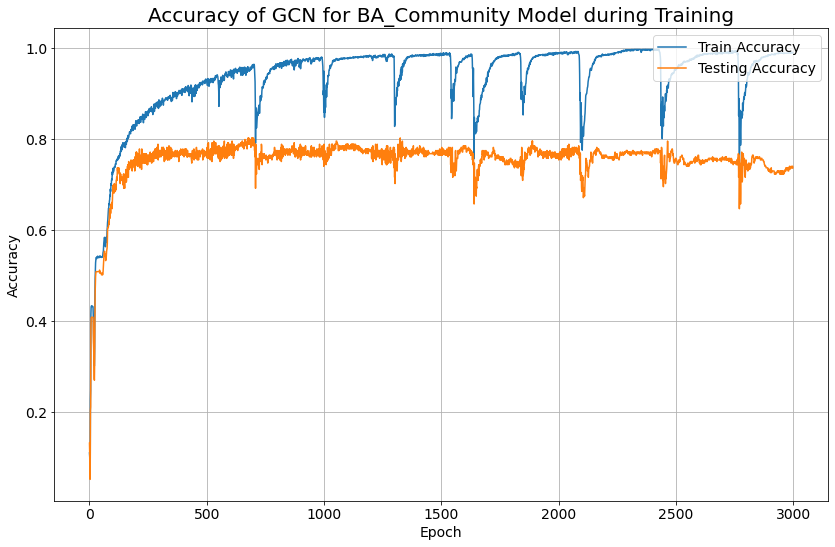

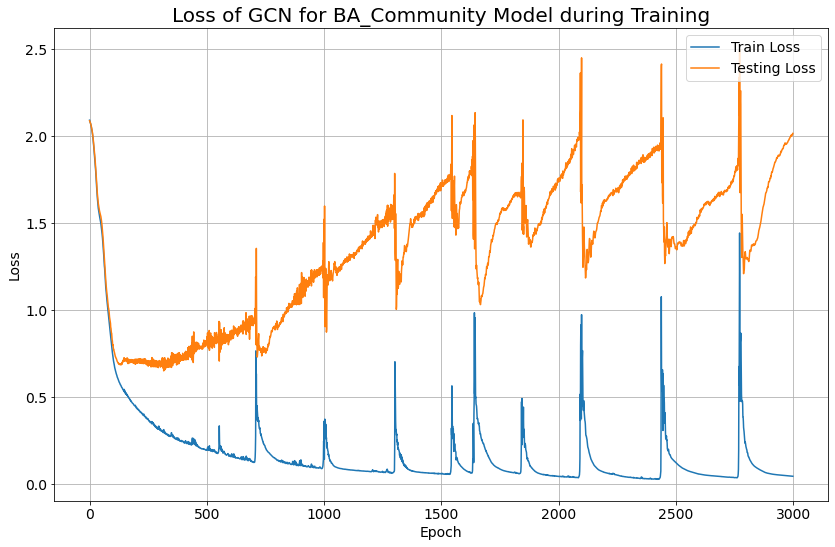

Num clusters:  188
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, cluster_encoding_size: 10


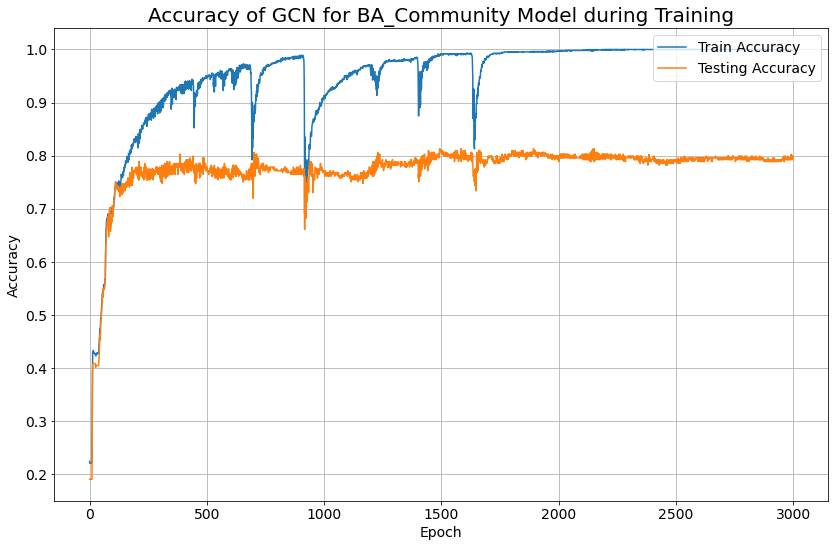

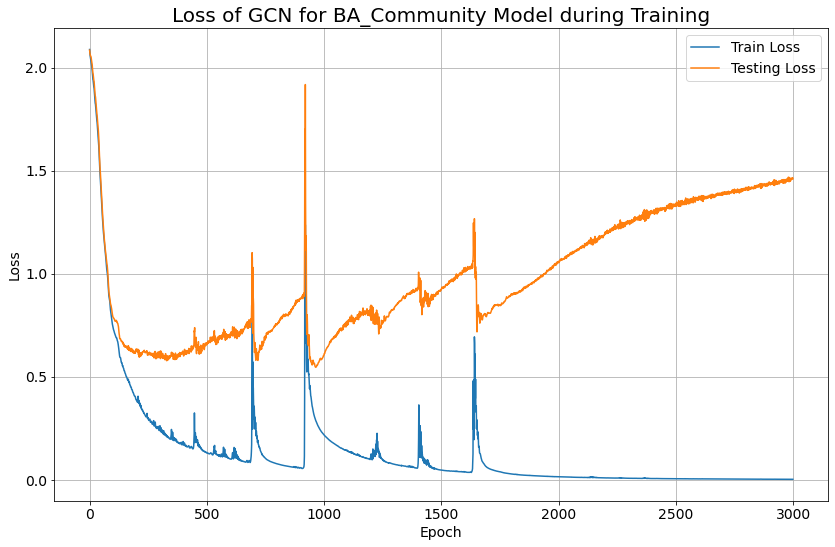

Num clusters:  495
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, cluster_encoding_size: 20


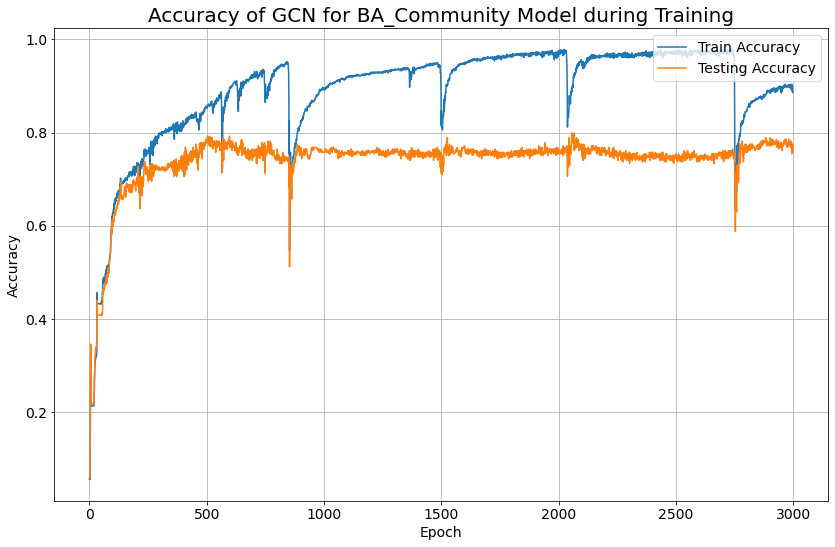

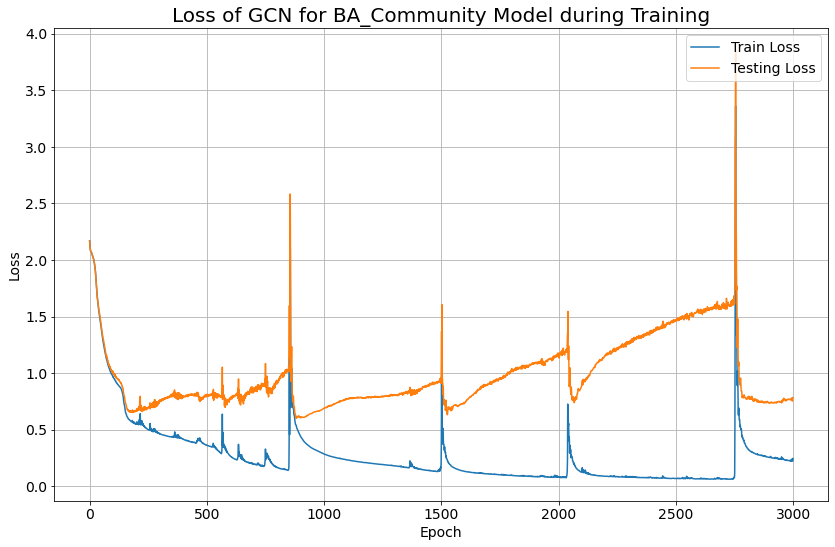

Num clusters:  217
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, cluster_encoding_size: 30


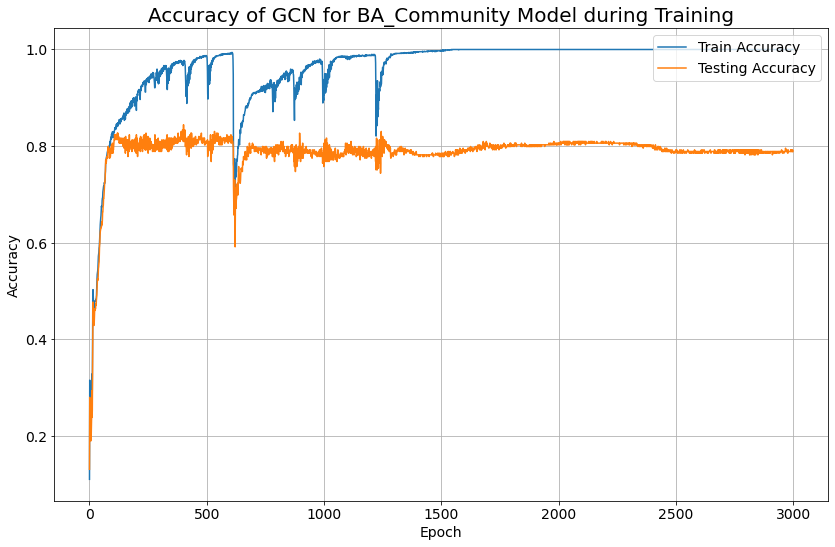

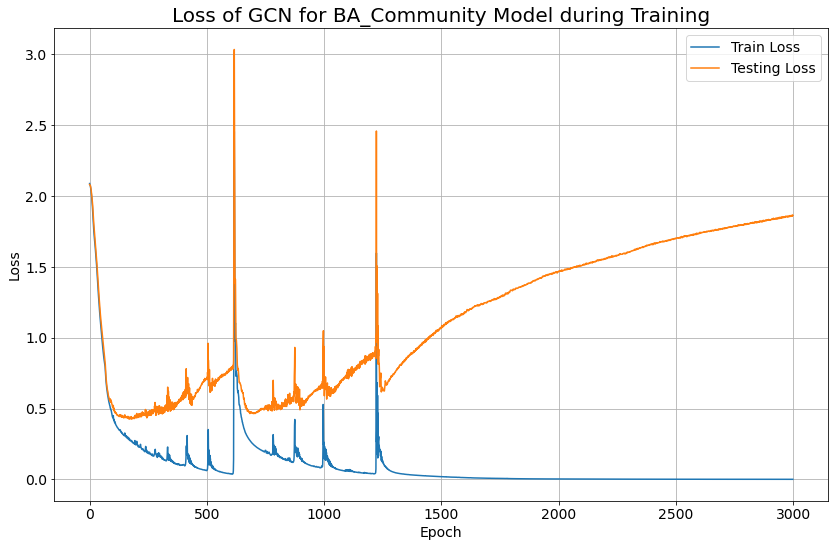

Num clusters:  934
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, cluster_encoding_size: 5


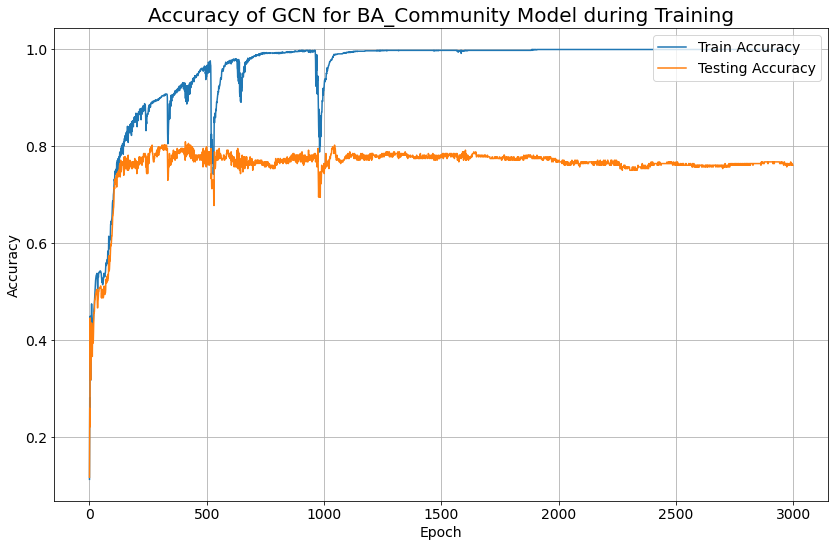

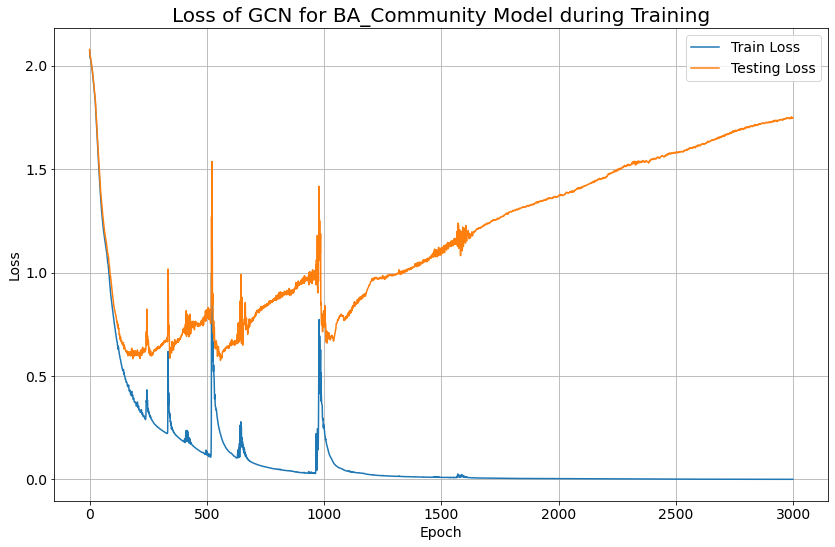

Num clusters:  260
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, cluster_encoding_size: 10


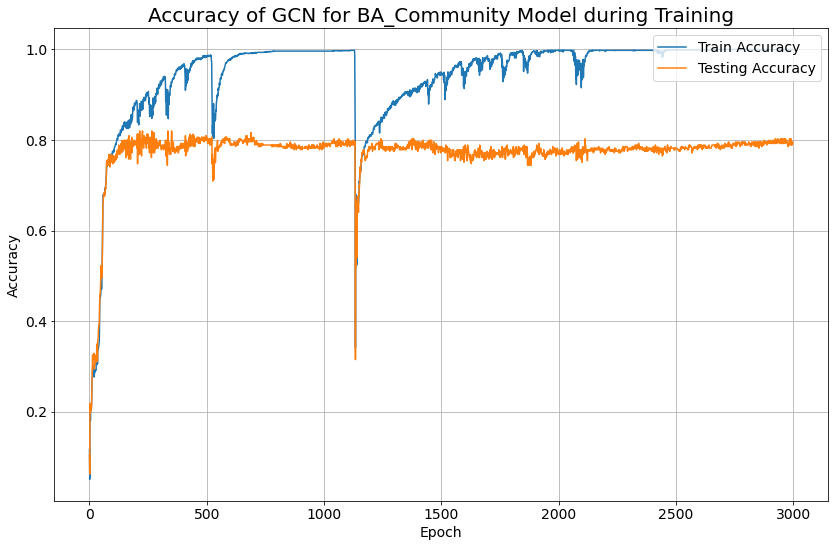

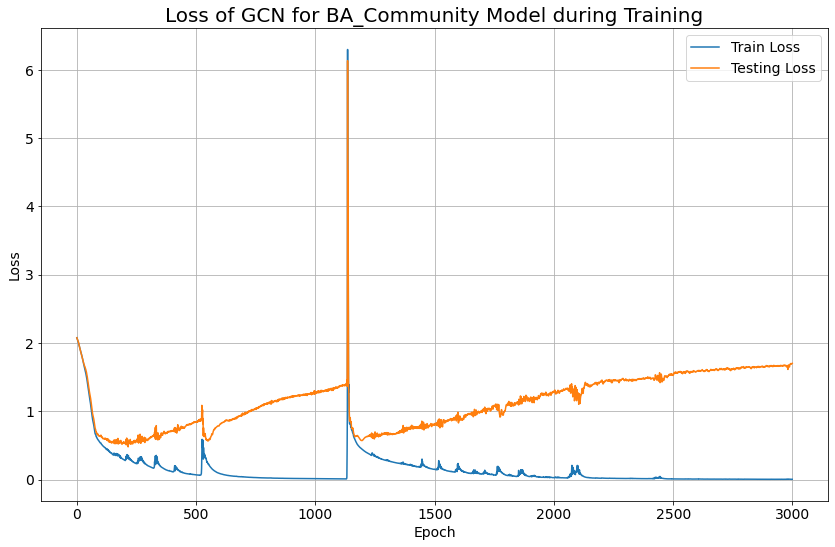

Num clusters:  268
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, cluster_encoding_size: 20


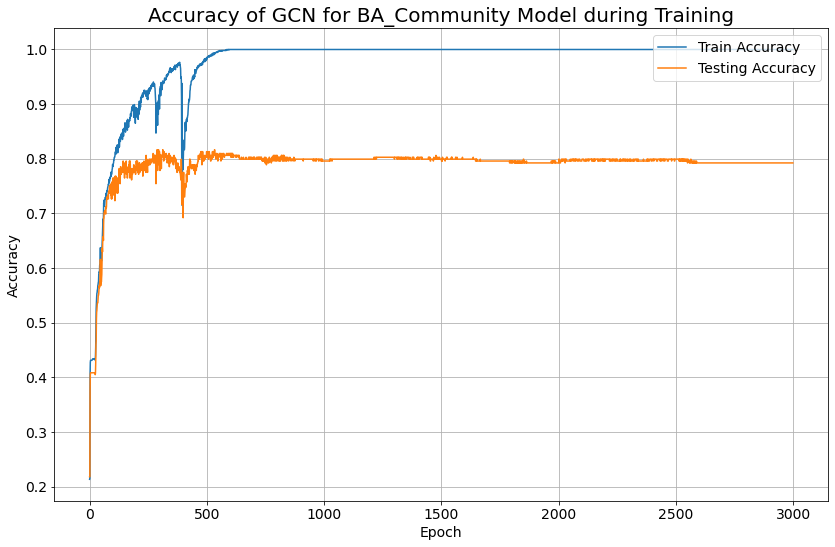

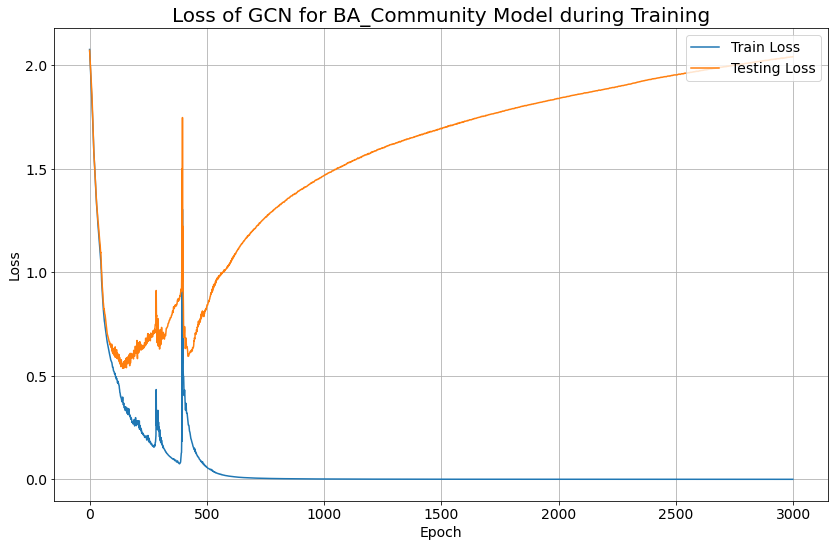

Num clusters:  566
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, cluster_encoding_size: 30


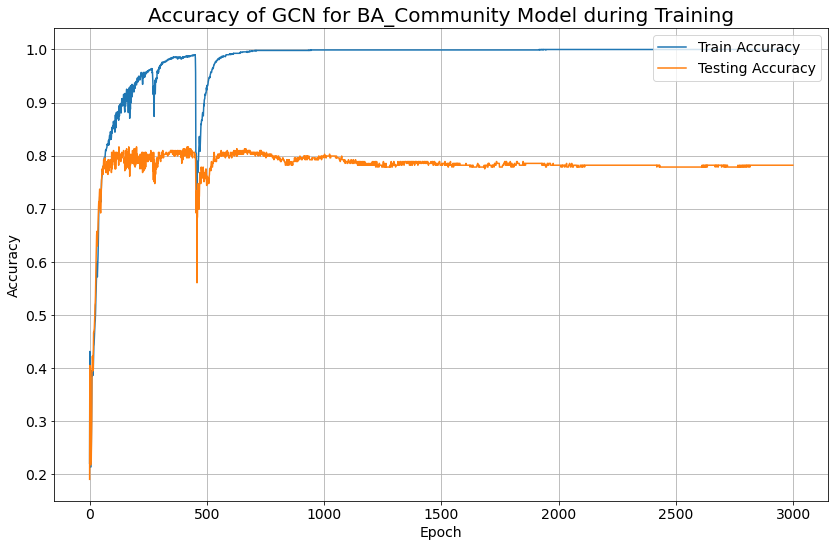

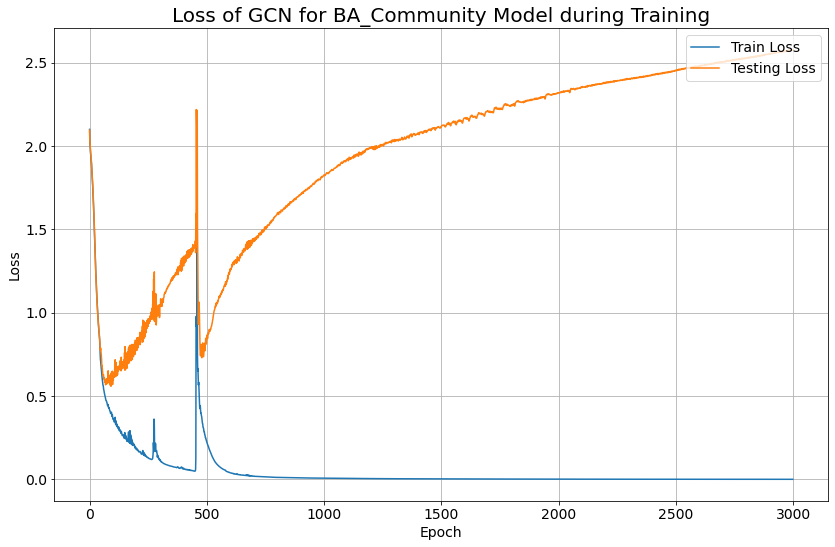

Num clusters:  1130
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, cluster_encoding_size: 5


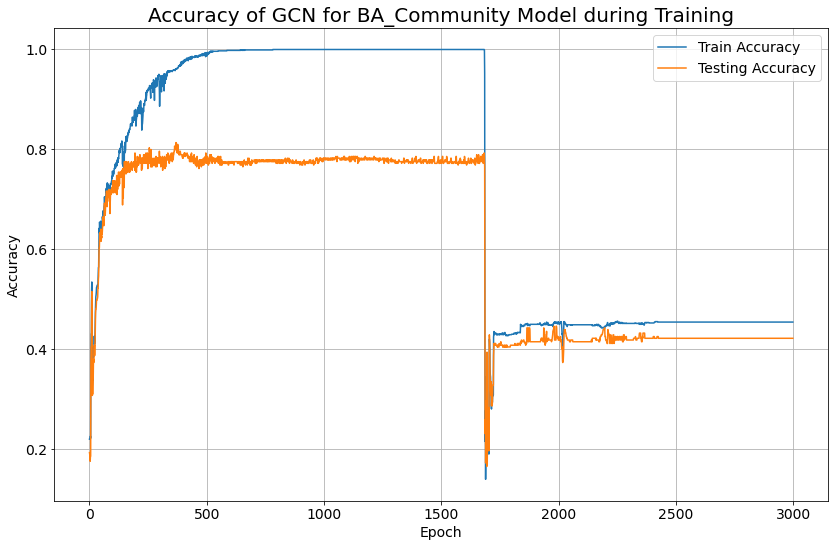

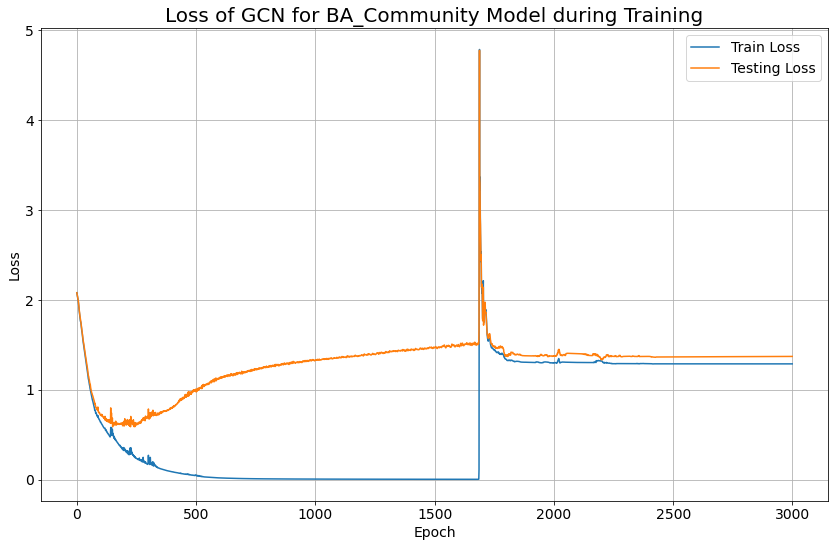

Num clusters:  3
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, cluster_encoding_size: 10


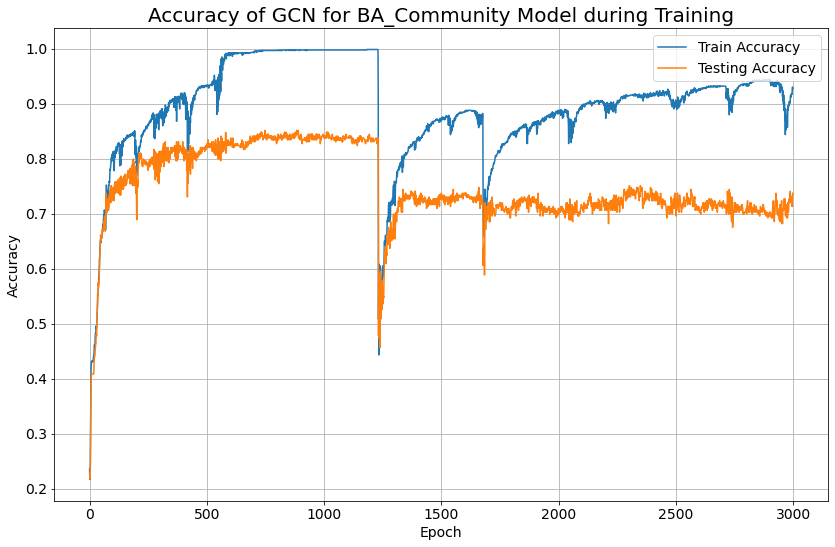

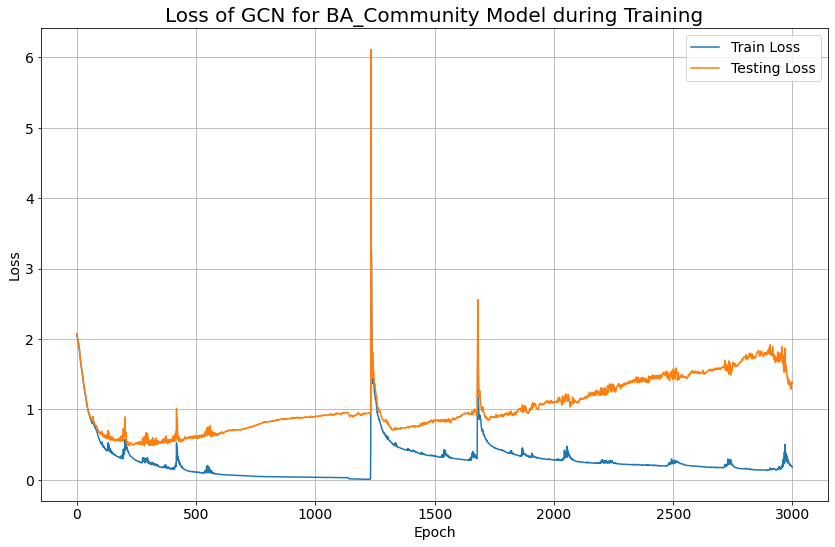

Num clusters:  151
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, cluster_encoding_size: 20


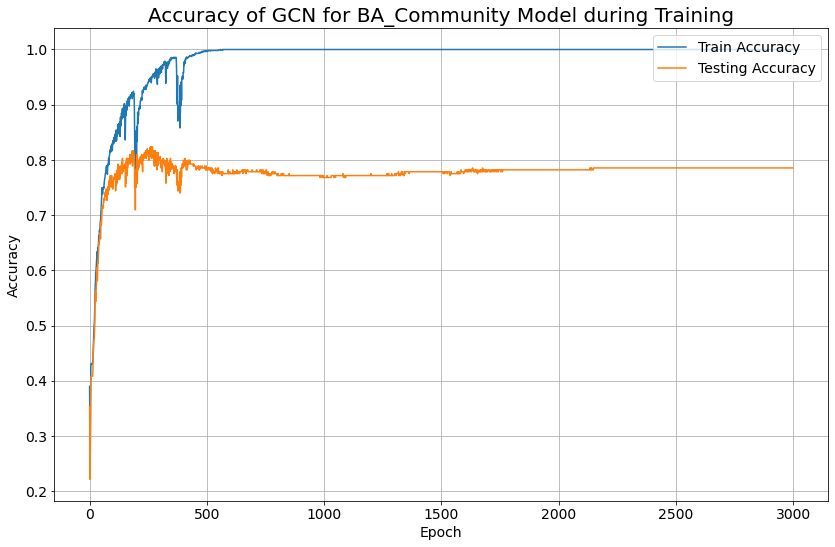

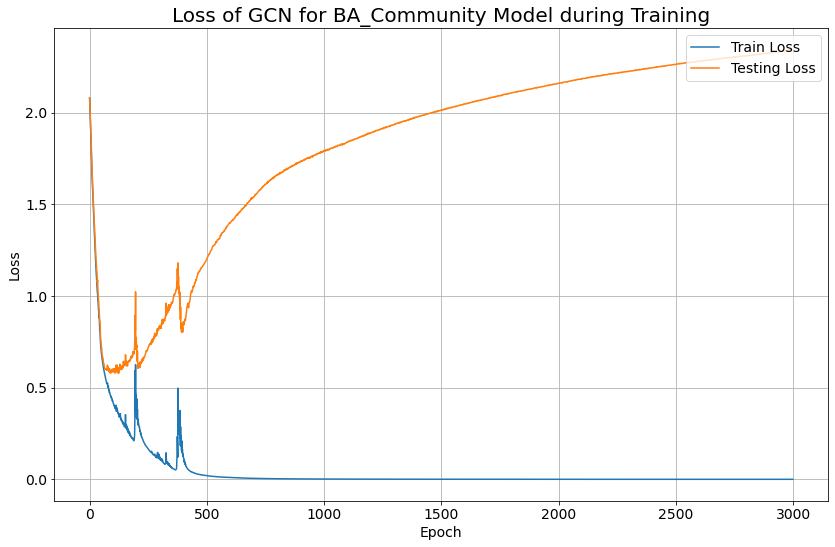

Num clusters:  799
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, cluster_encoding_size: 30


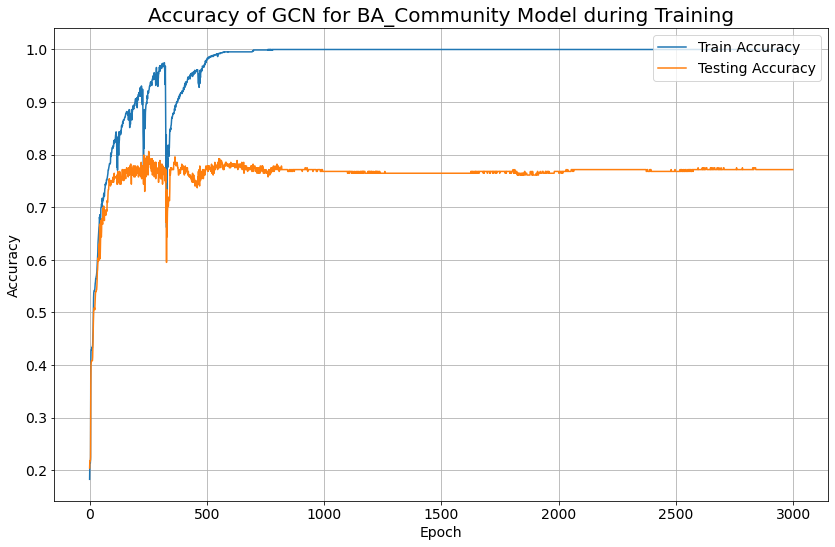

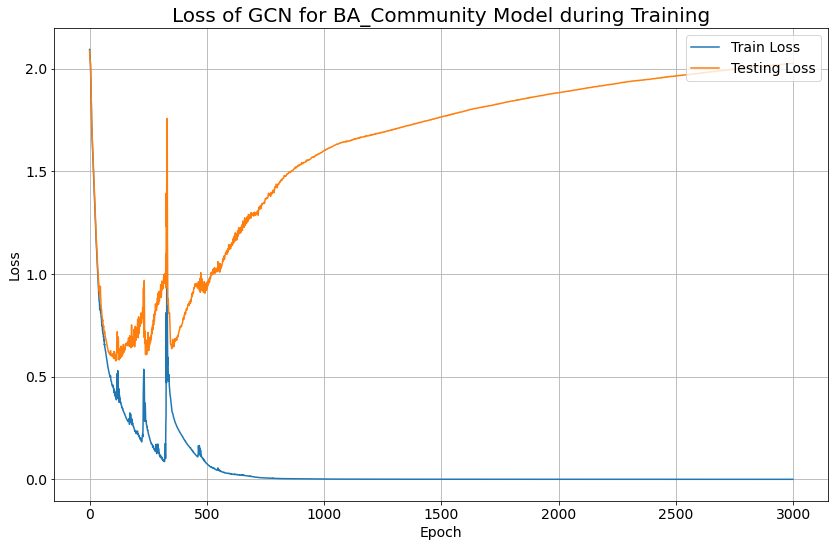

Num clusters:  780
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, cluster_encoding_size: 5


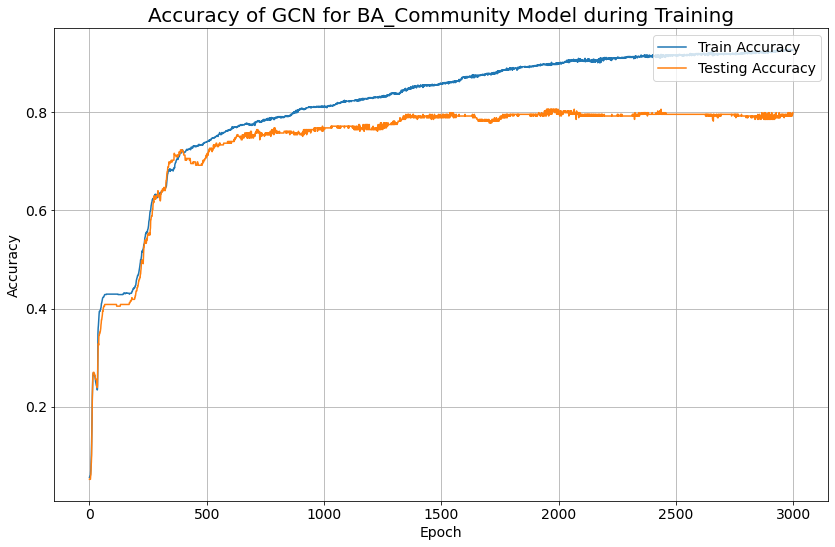

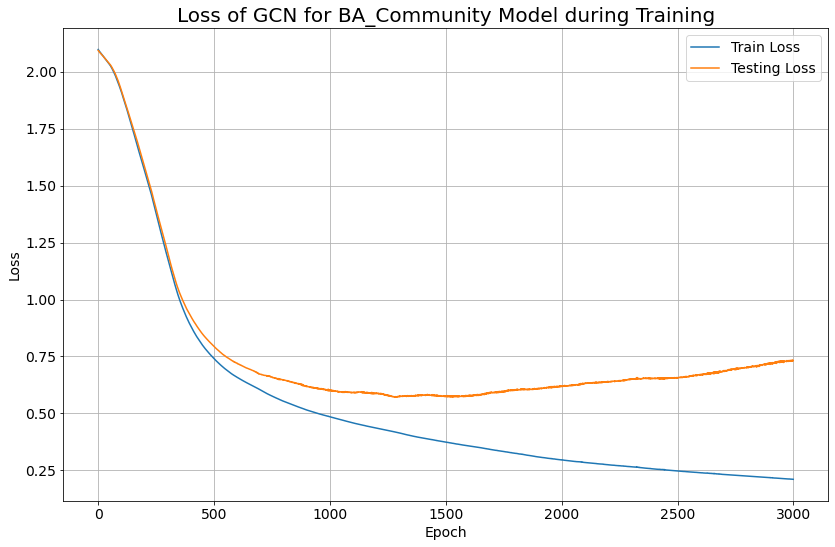

Num clusters:  201
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, cluster_encoding_size: 10


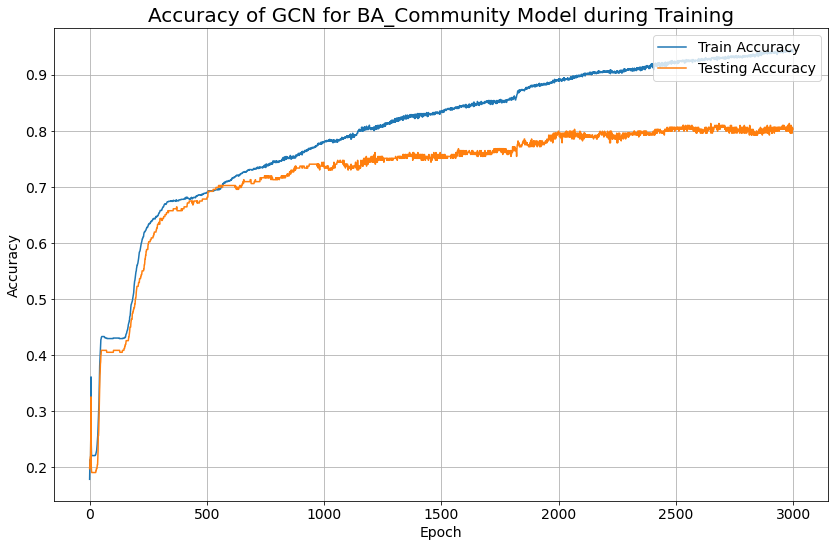

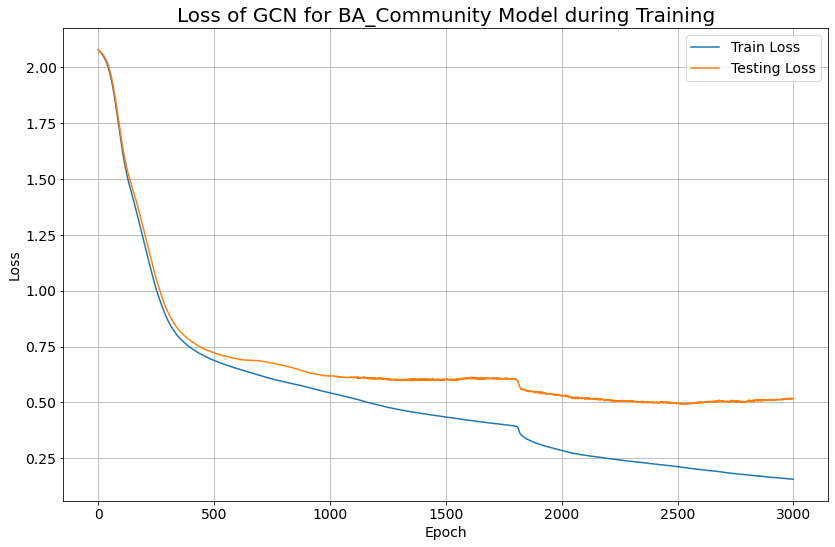

Num clusters:  537
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, cluster_encoding_size: 20


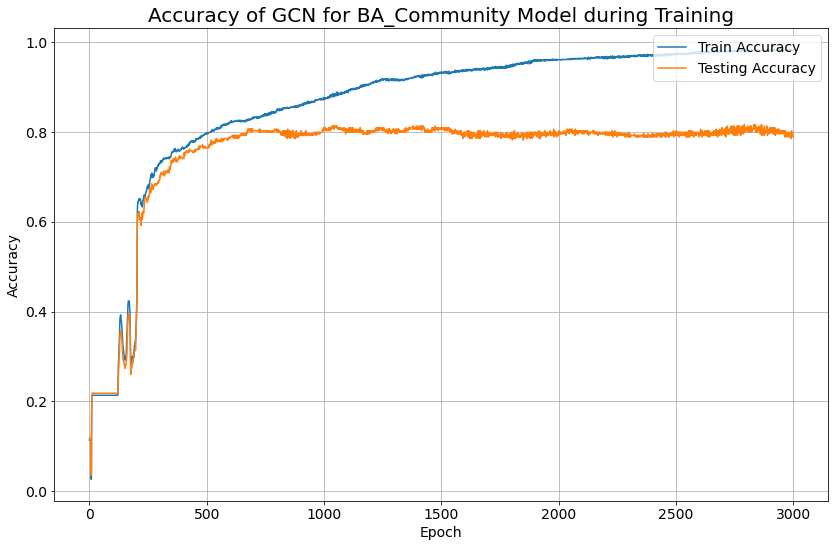

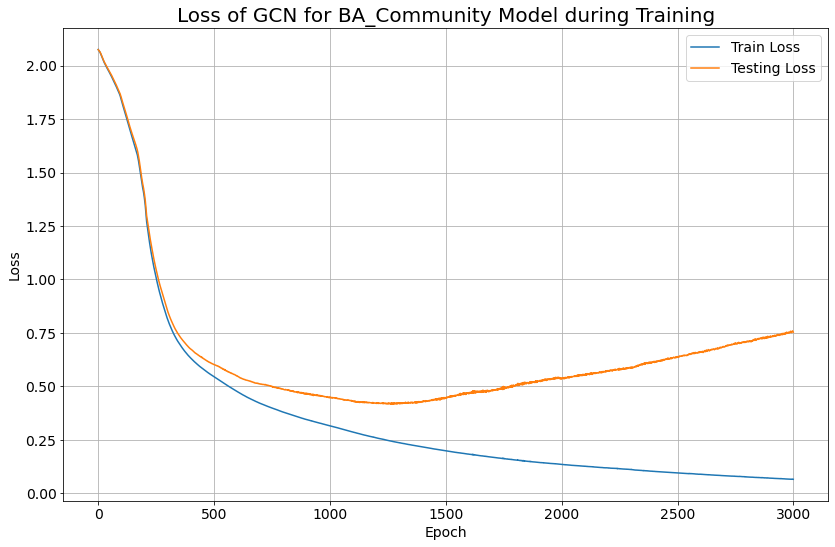

Num clusters:  914
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, cluster_encoding_size: 30


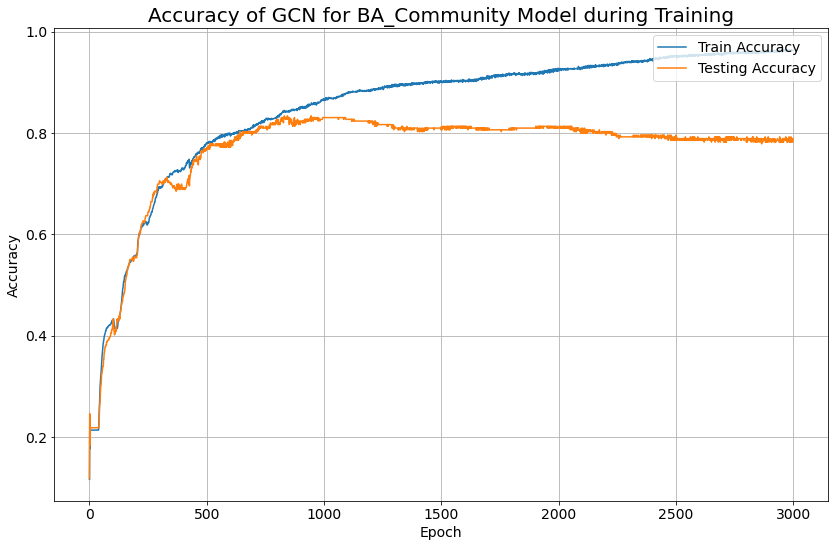

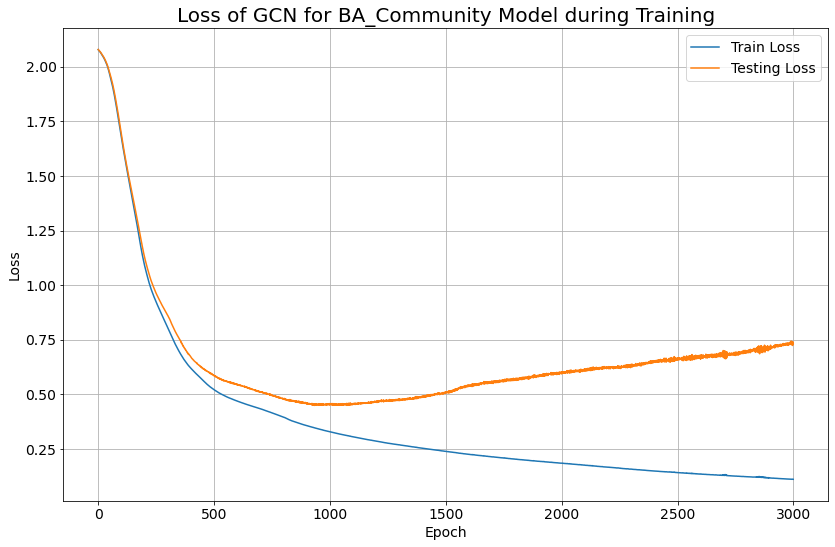

Num clusters:  1069
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, cluster_encoding_size: 5


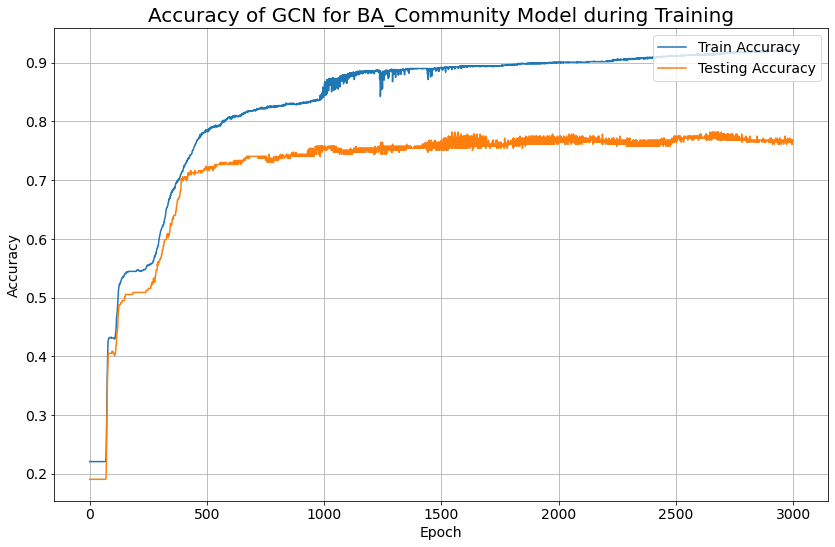

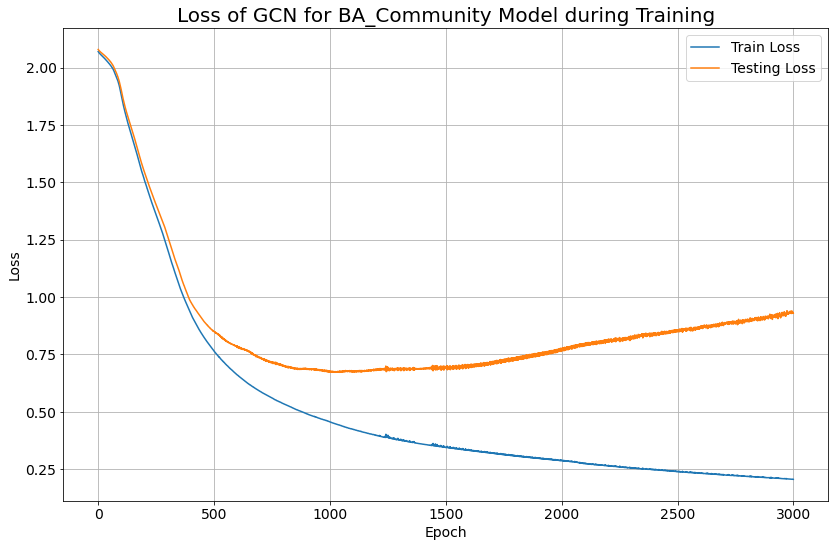

Num clusters:  131
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, cluster_encoding_size: 10


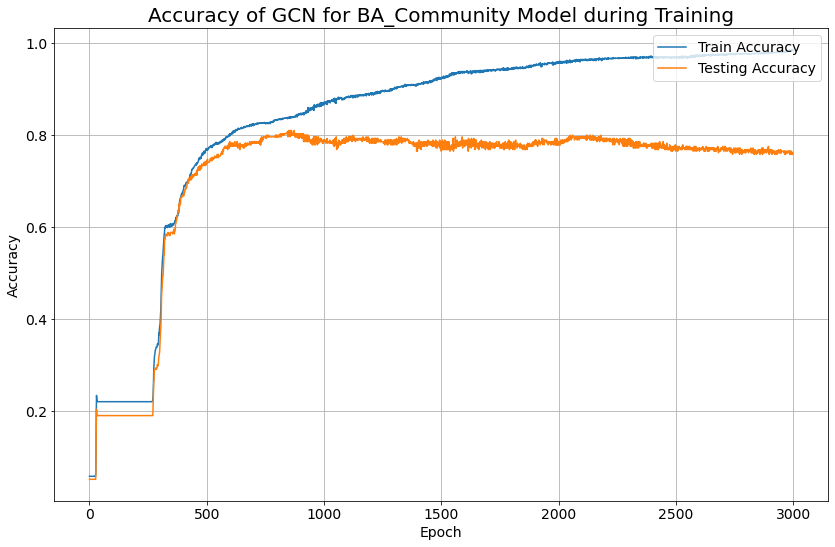

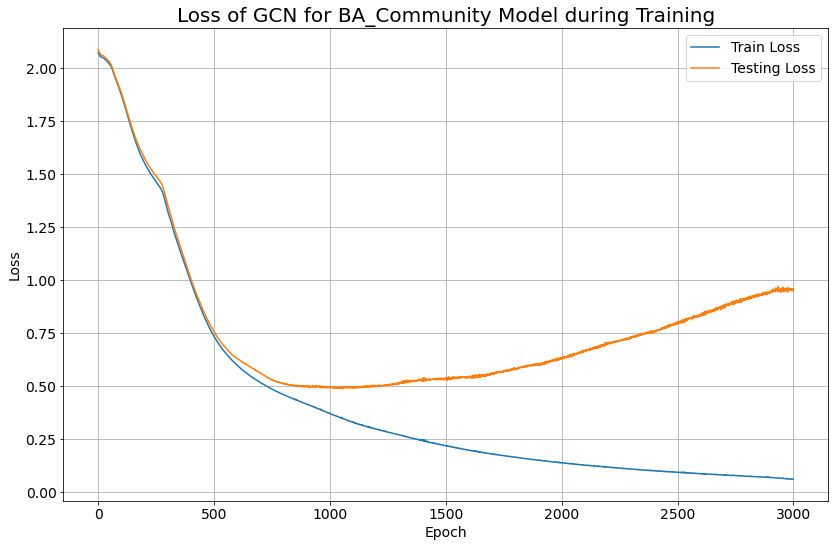

Num clusters:  239
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, cluster_encoding_size: 20


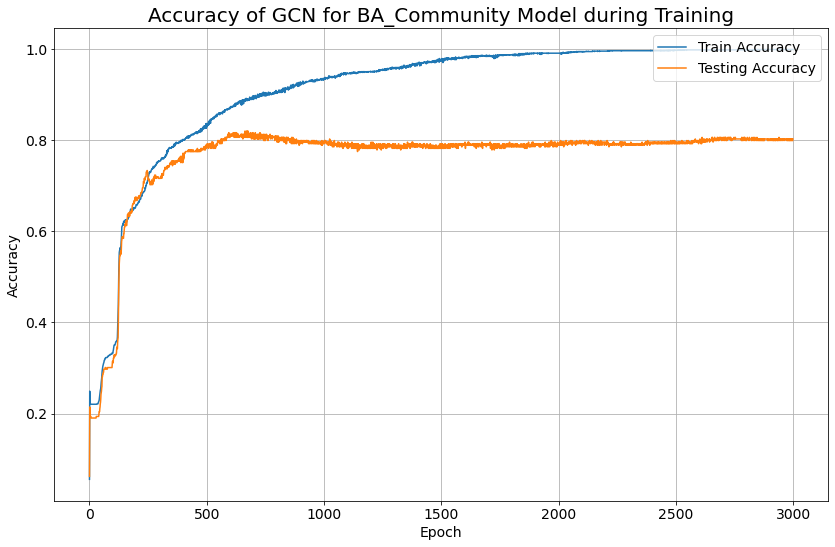

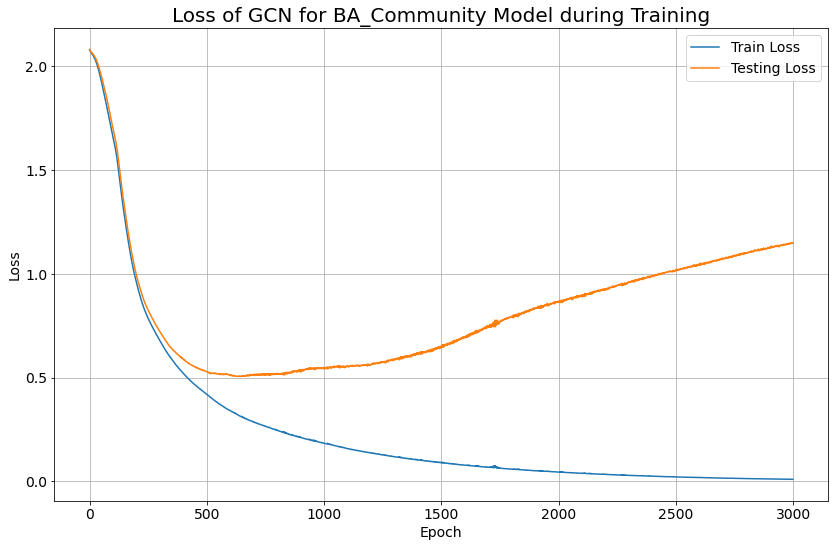

Num clusters:  886
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, cluster_encoding_size: 30


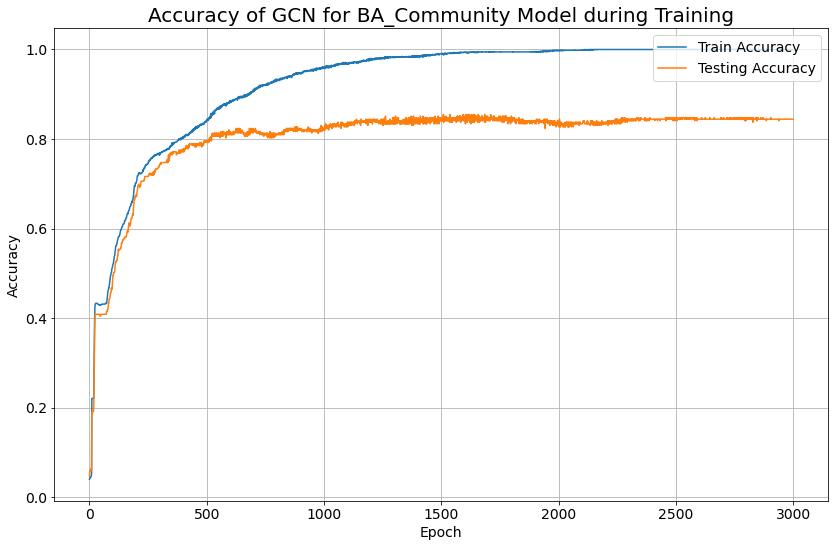

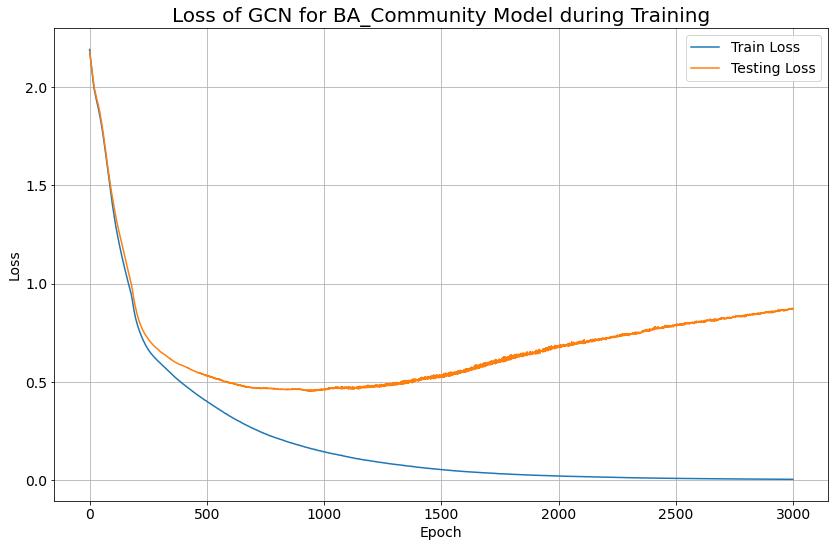

Num clusters:  969
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, cluster_encoding_size: 5


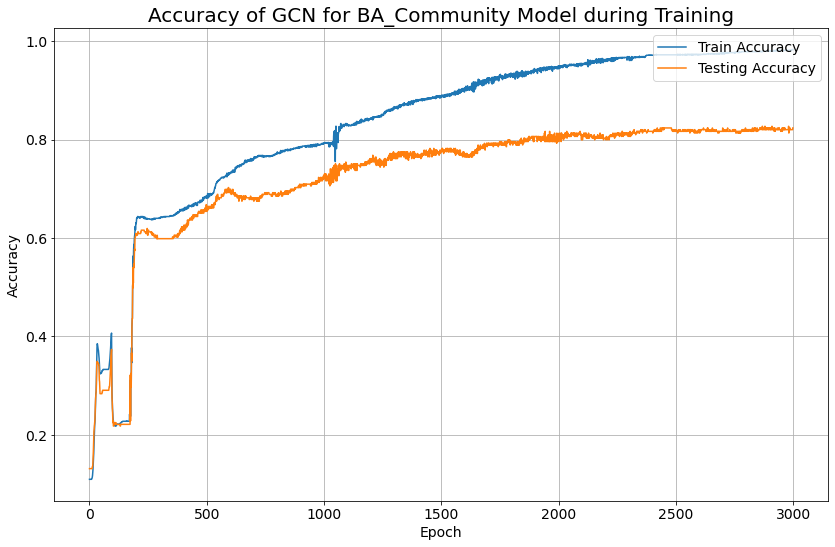

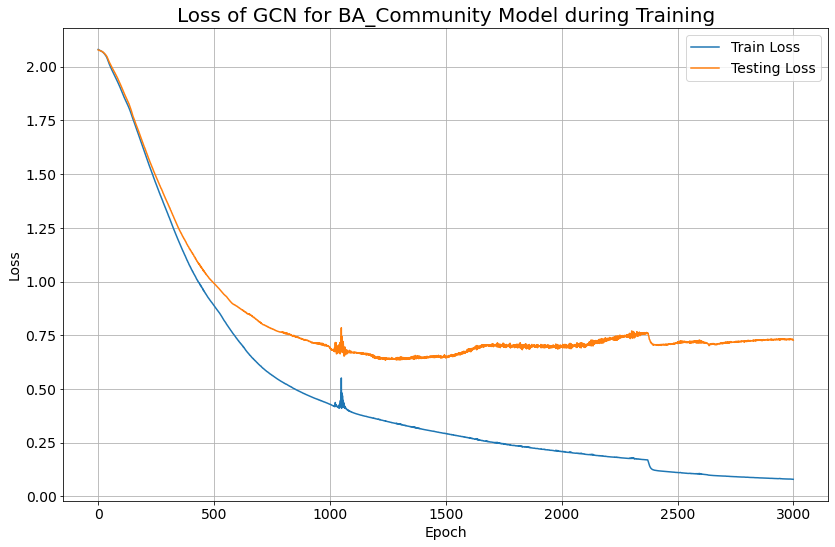

Num clusters:  96
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, cluster_encoding_size: 10


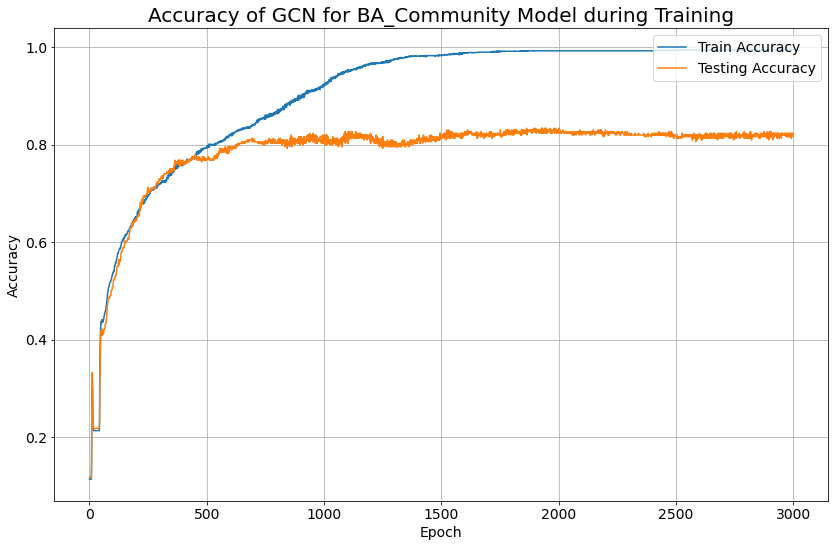

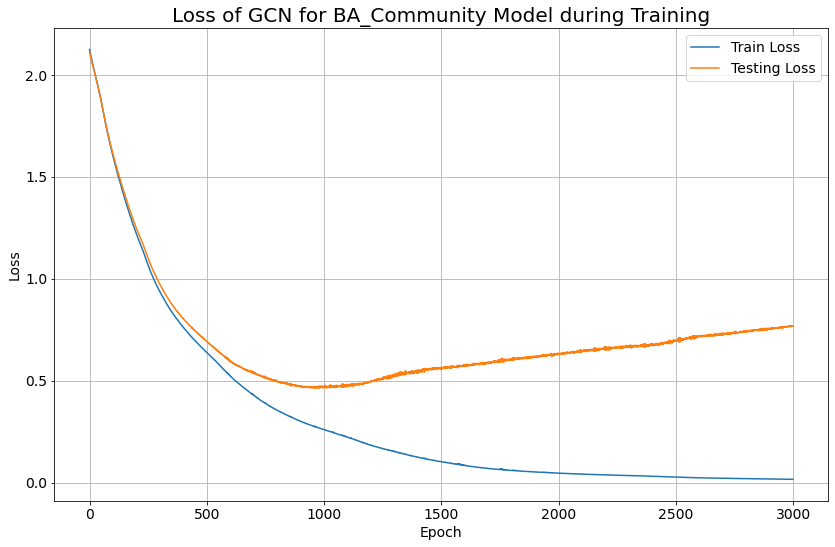

Num clusters:  274
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, cluster_encoding_size: 20


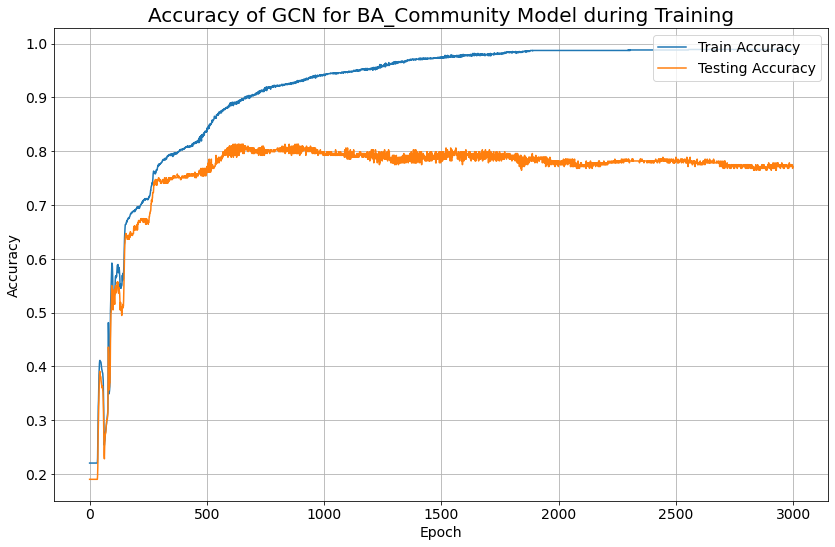

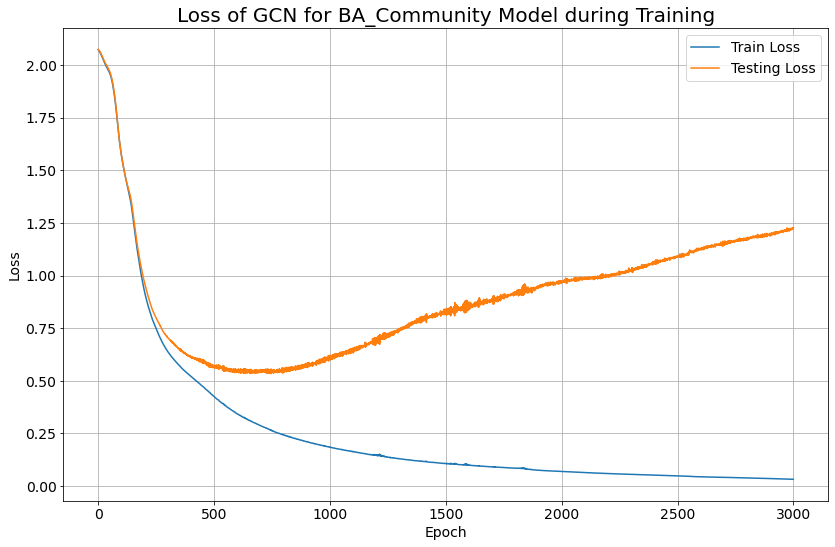

Num clusters:  701
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, cluster_encoding_size: 30


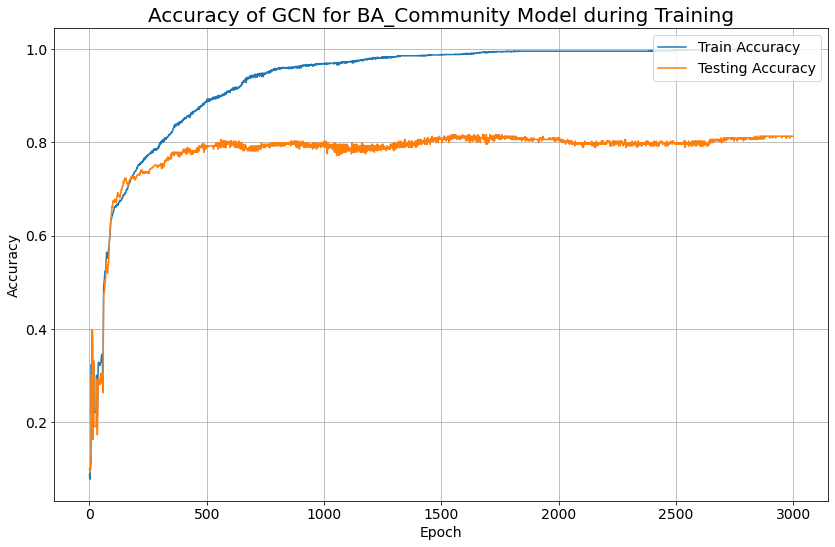

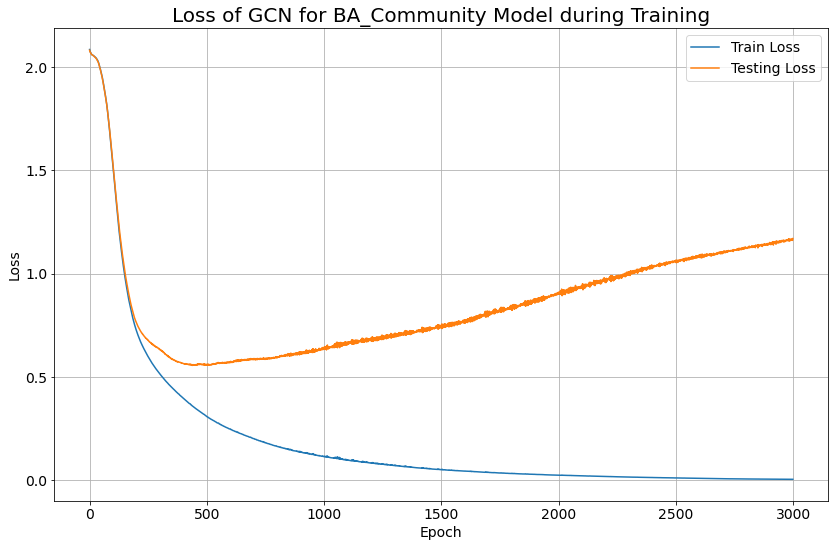

Num clusters:  1103
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, cluster_encoding_size: 5


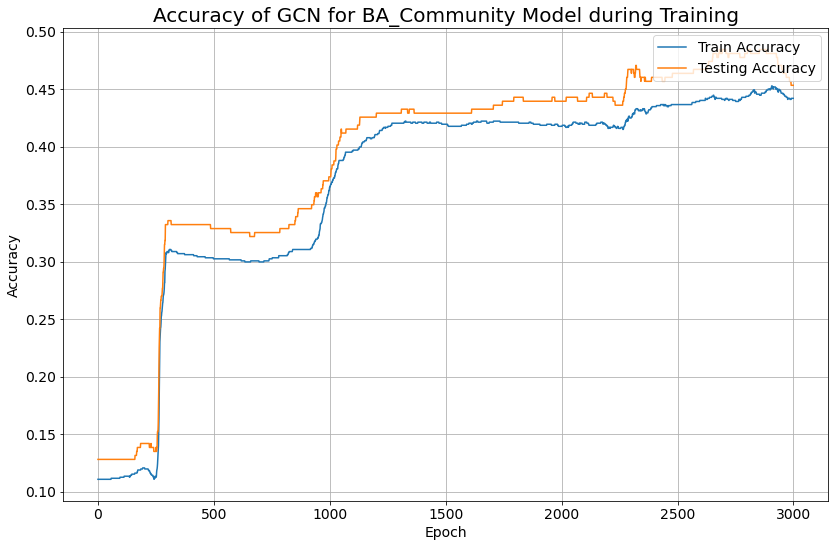

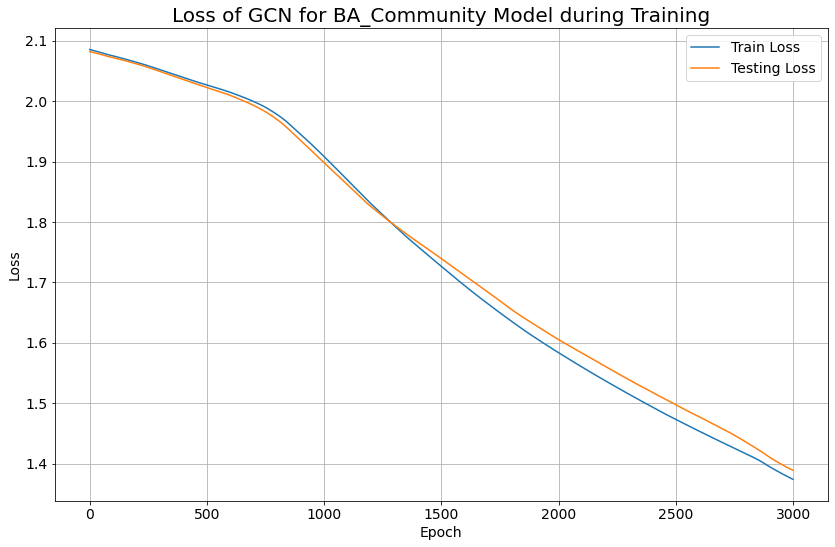

Num clusters:  37
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, cluster_encoding_size: 10


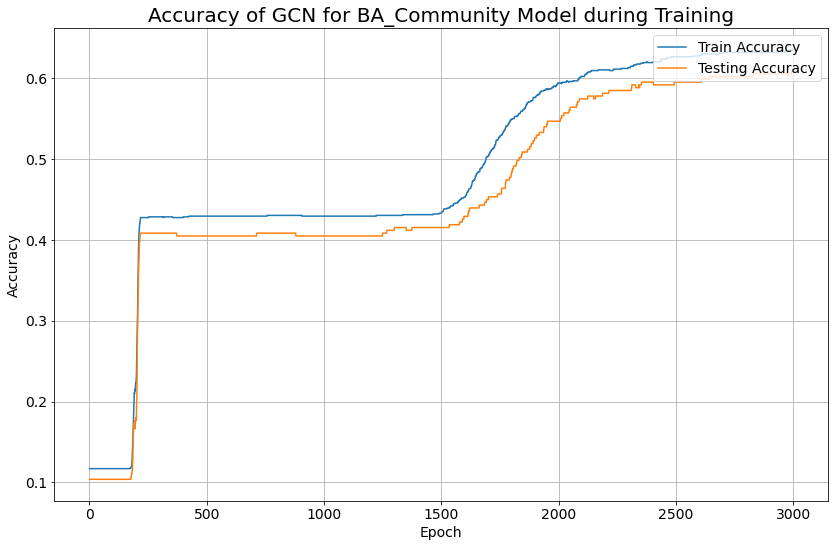

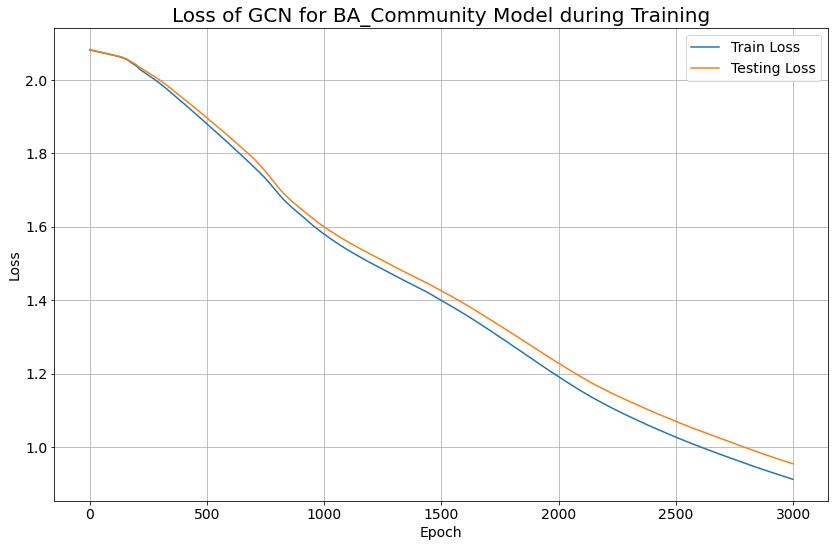

Num clusters:  120
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, cluster_encoding_size: 20


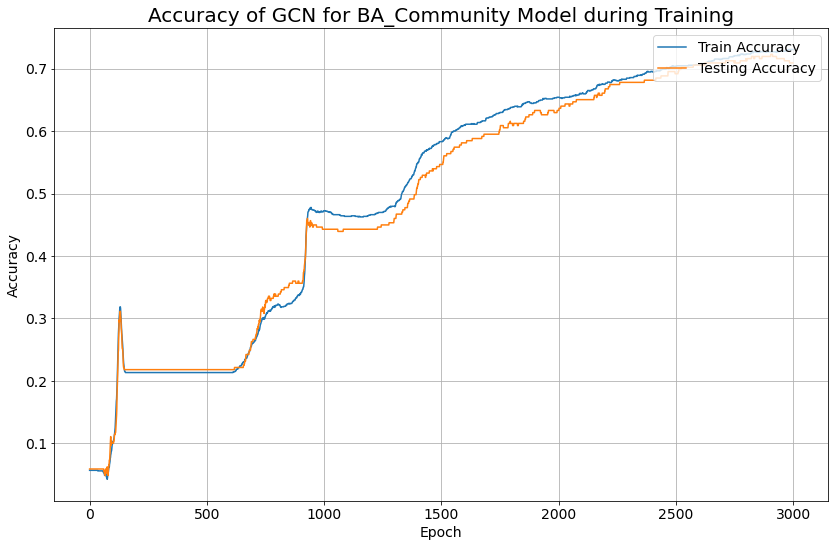

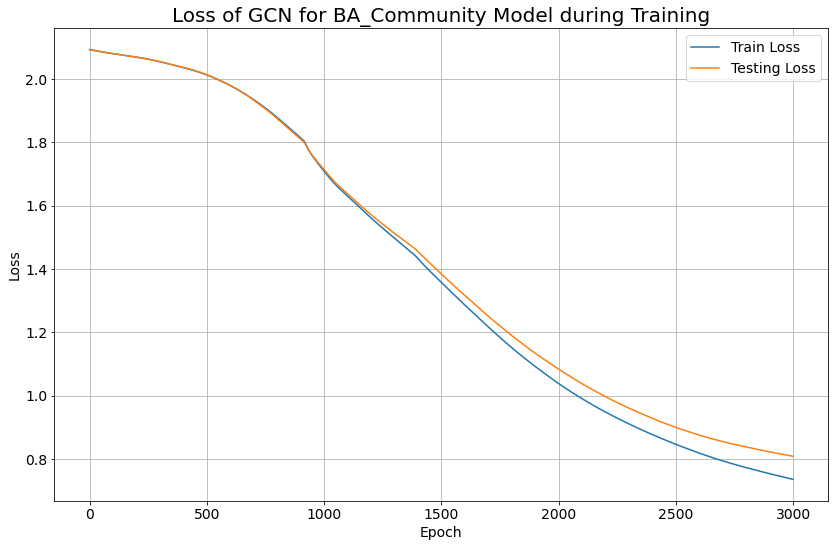

Num clusters:  315
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, cluster_encoding_size: 30


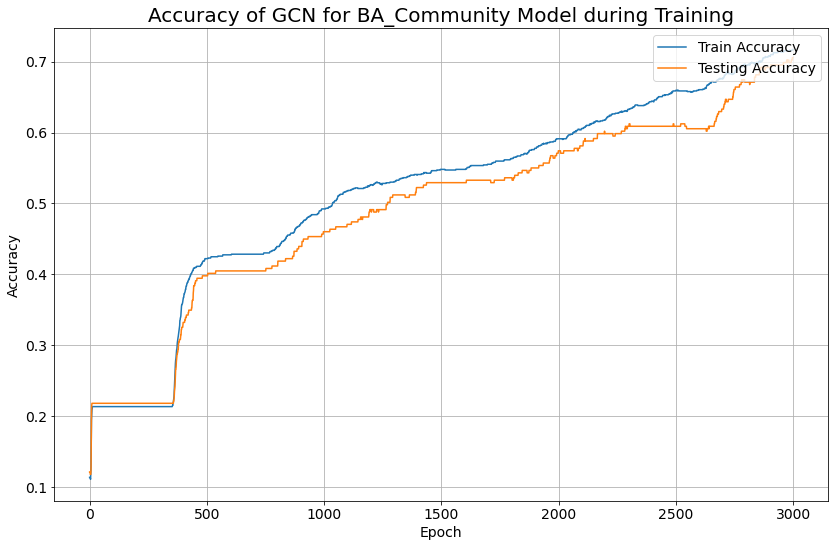

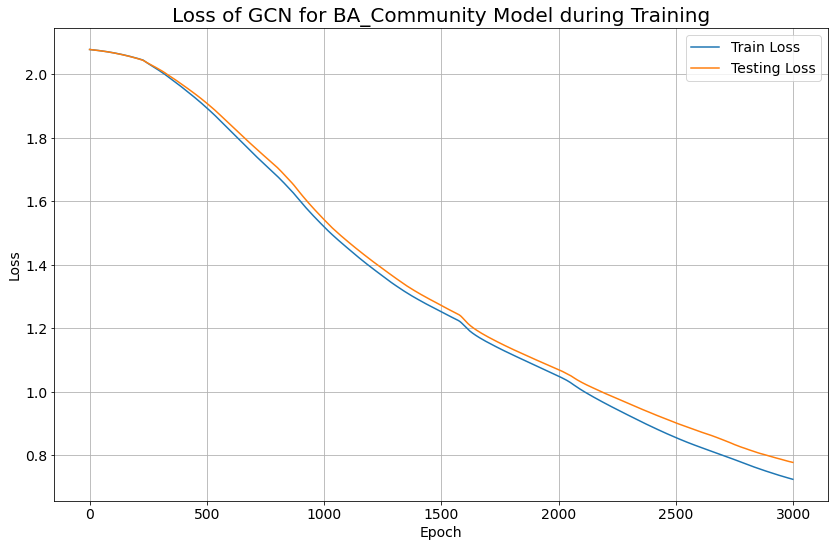

Num clusters:  538
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, cluster_encoding_size: 5


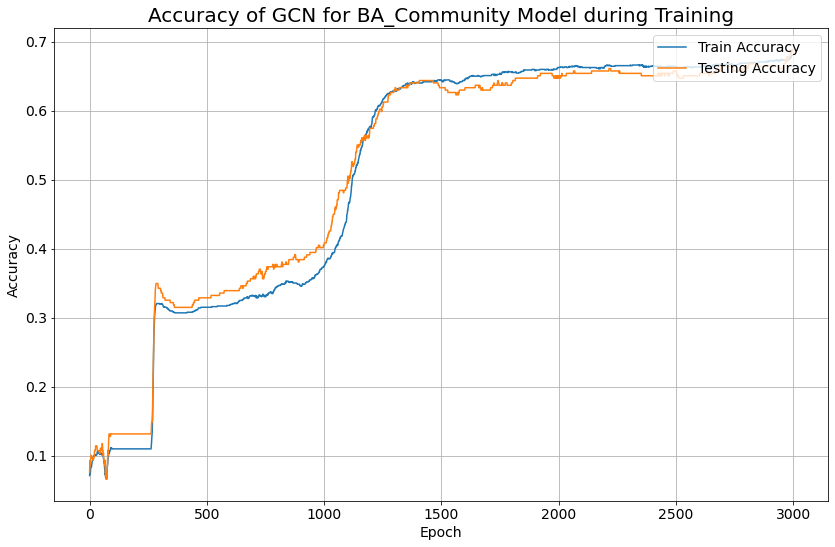

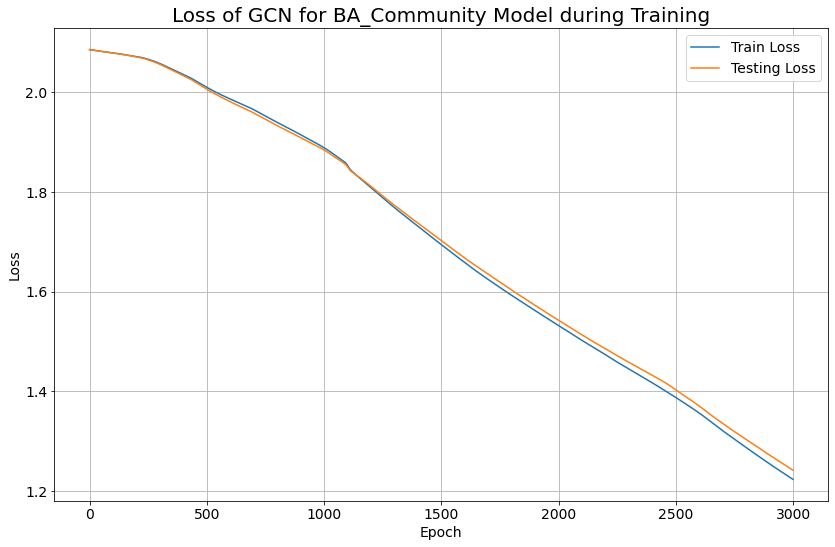

Num clusters:  45
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, cluster_encoding_size: 10


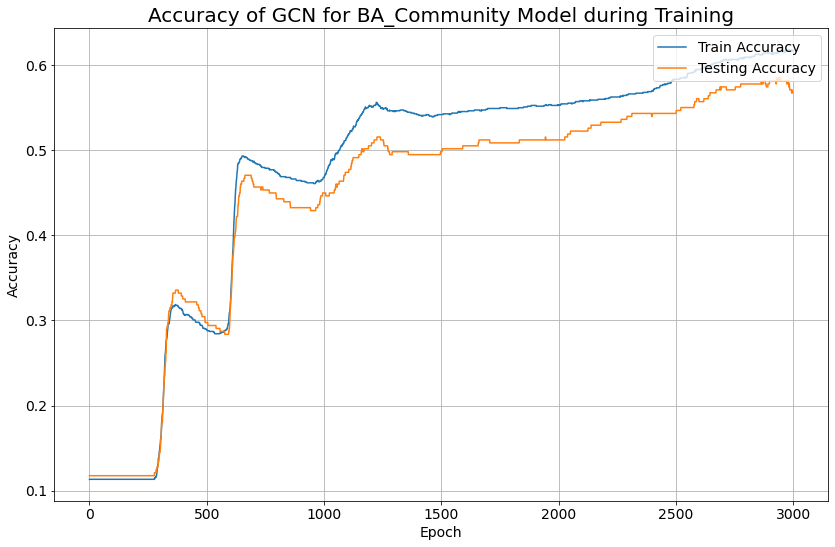

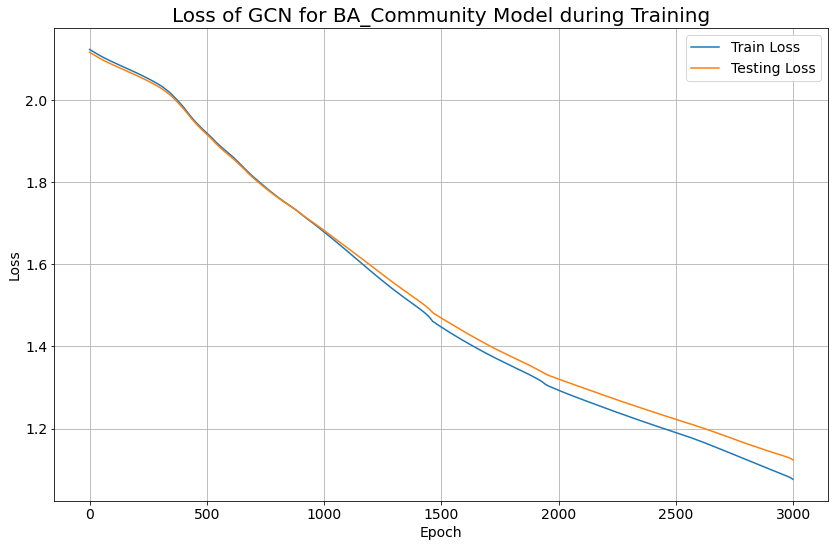

Num clusters:  112
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, cluster_encoding_size: 20


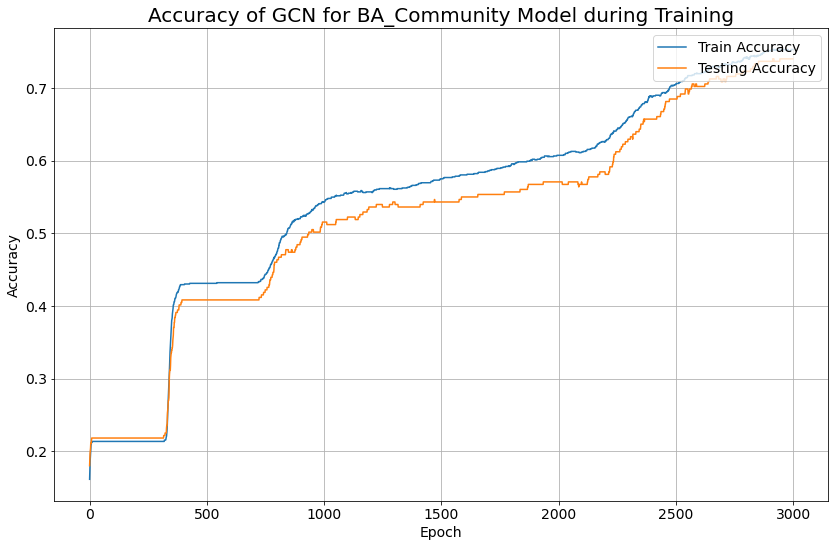

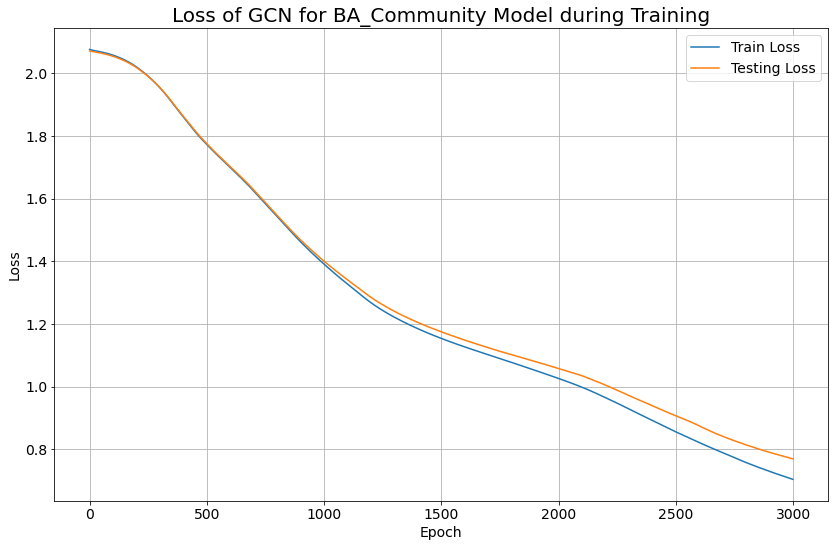

Num clusters:  208
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, cluster_encoding_size: 30


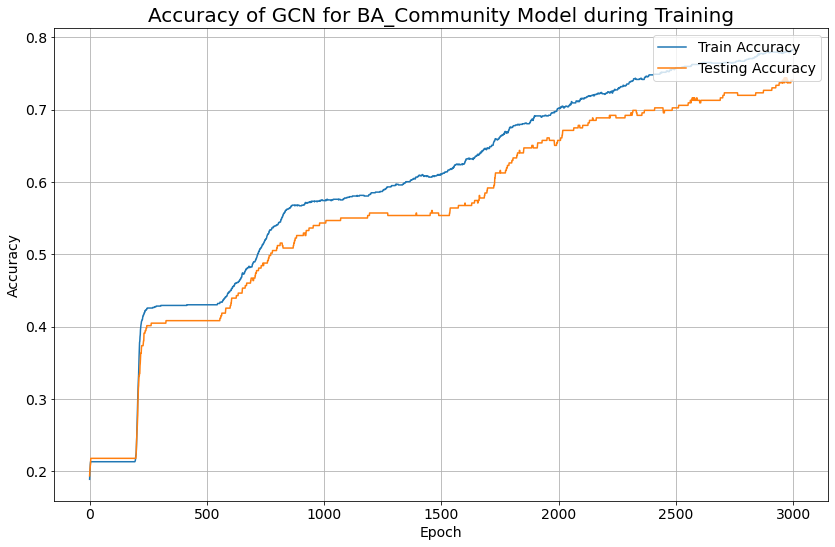

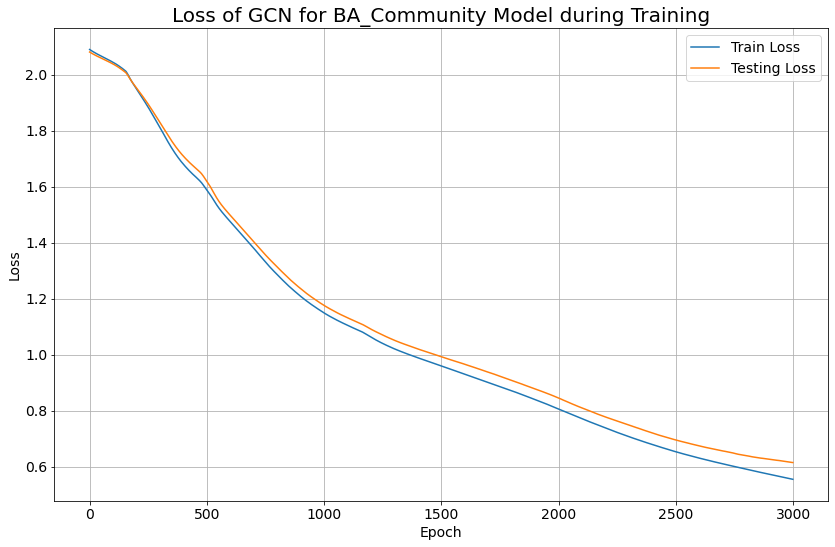

Num clusters:  697
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, cluster_encoding_size: 5


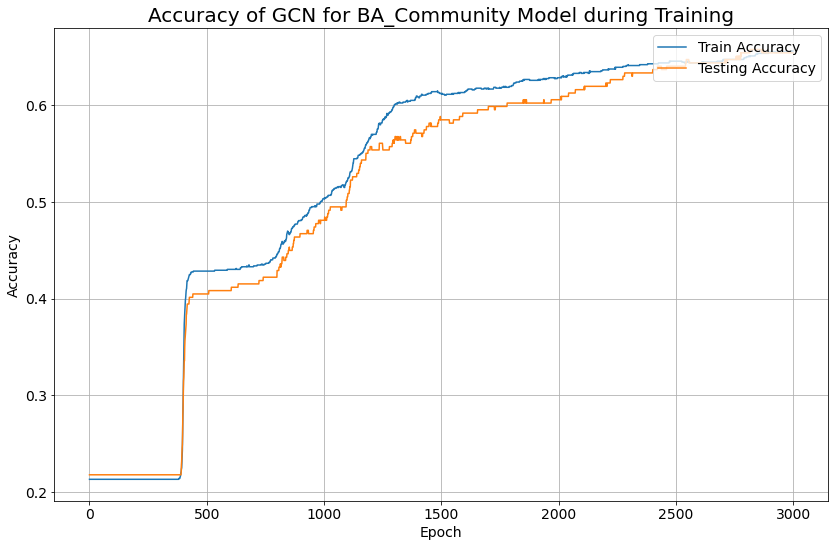

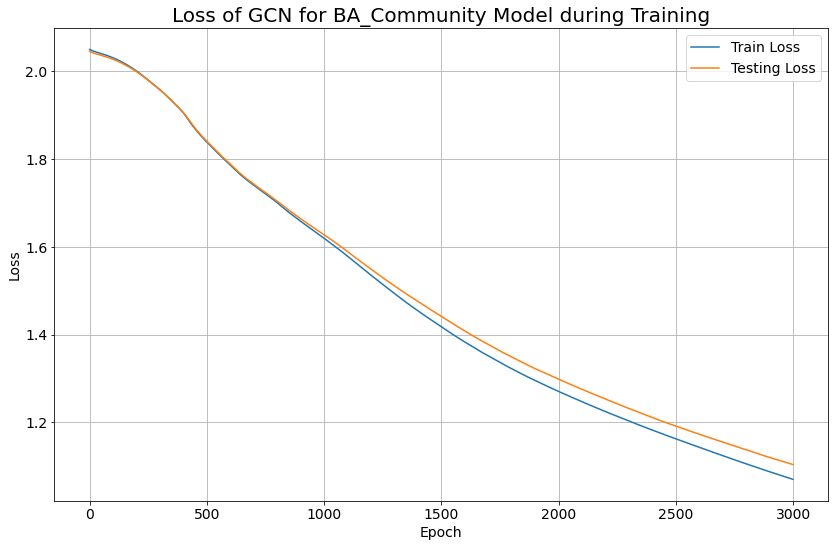

Num clusters:  33
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, cluster_encoding_size: 10


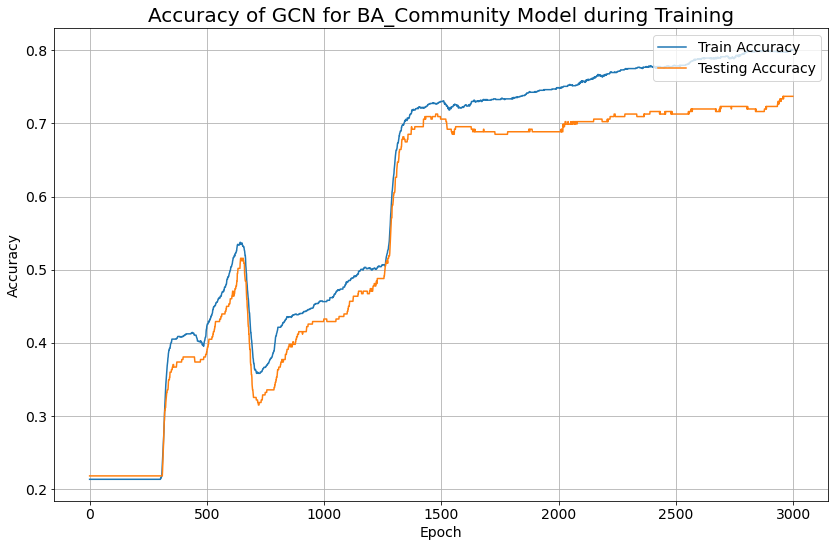

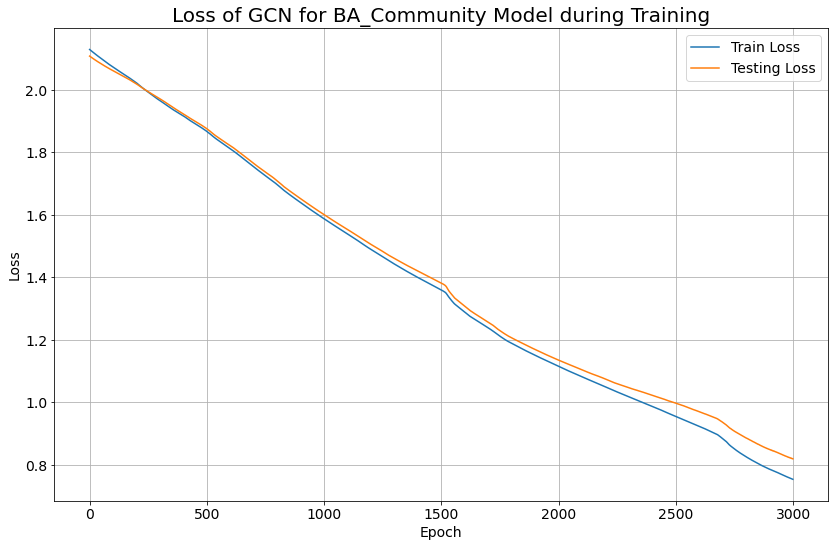

Num clusters:  100
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, cluster_encoding_size: 20


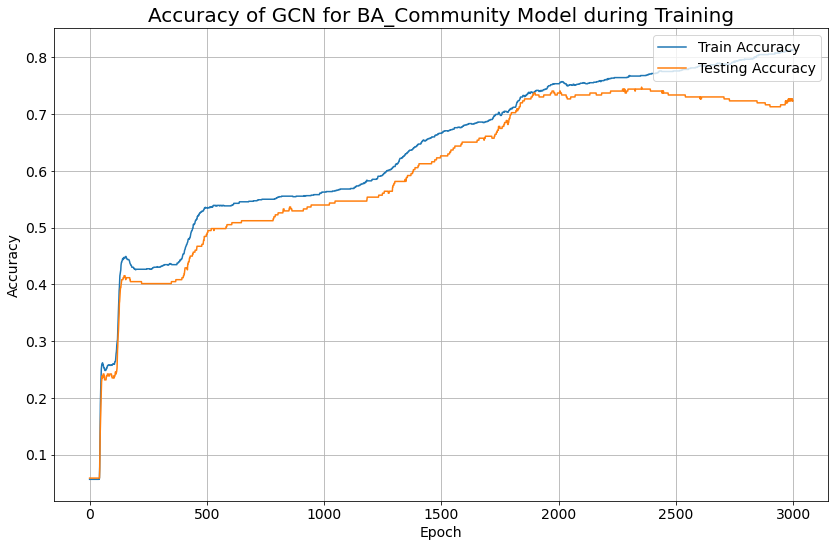

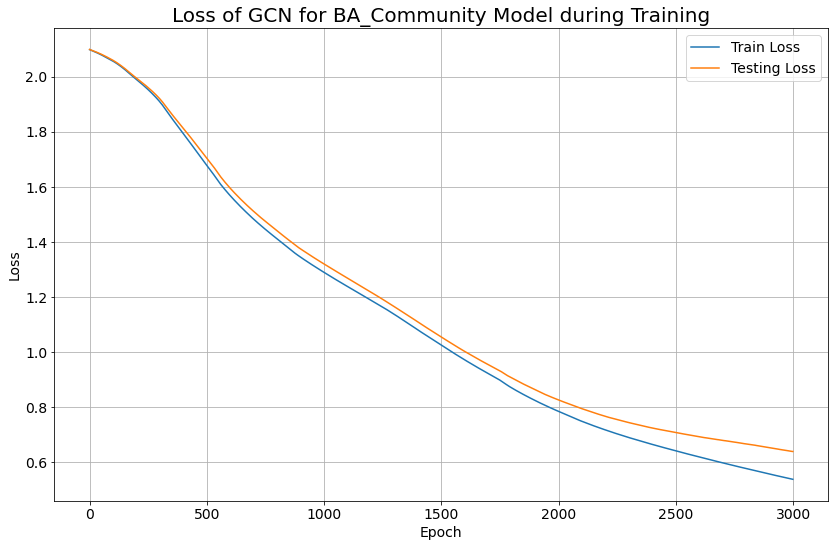

Num clusters:  376
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, cluster_encoding_size: 30


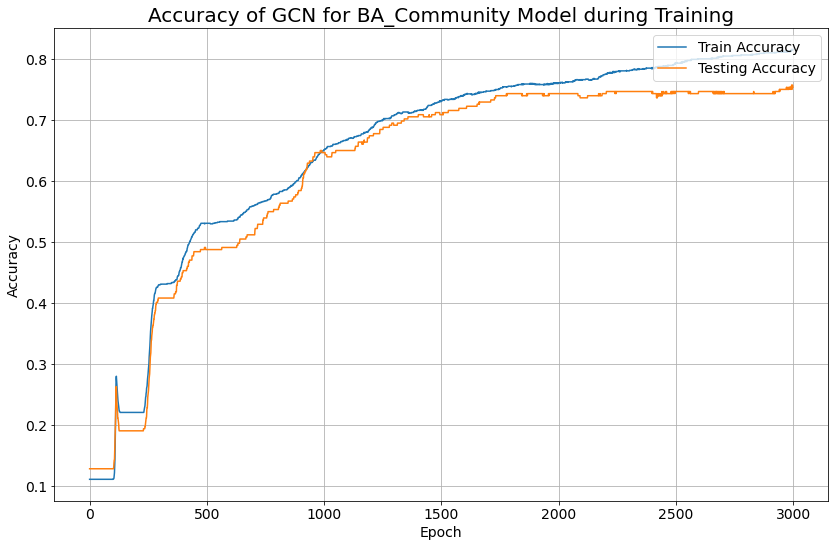

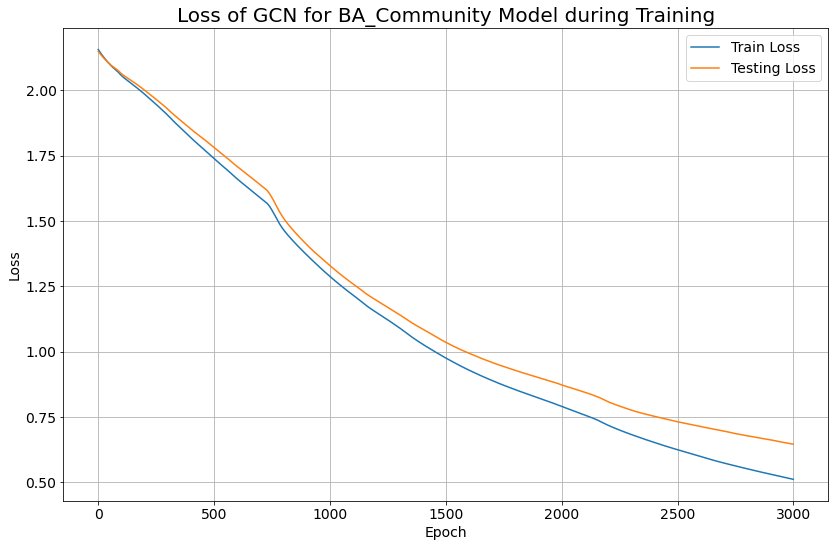

Num clusters:  575
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------



In [6]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
seed = 42

seed_everything(seed)
lr_values = [0.01, 0.001, 0.0001]
hidden_units_values = [10, 20, 30]
cluster_encoding_size_values = [5, 10, 20, 30]

# load data
G, labels = data_utils.load_syn_data(DATASET_NAME, path_prefix="../")
data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)

for lr in lr_values:
    for hidden_units in hidden_units_values:
        for cluster_encoding_size in cluster_encoding_size_values:
            print("\nSTART EXPERIMENT-----------------------------------------\n")
            print(f"lr: {lr}, hu: {hidden_units}, cluster_encoding_size: {cluster_encoding_size}")

            path = os.path.join("..", "..", "output", "grid_search", DATASET_NAME, f"seed_{seed}_lr_{lr}_hu_{hidden_units}_cluster_{cluster_encoding_size}")
            data_utils.create_path(path)
            
            run_grid_search(data, lr, hidden_units, cluster_encoding_size, path)

            print("\nEND EXPERIMENT-------------------------------------------\n")


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 40, cluster_encoding_size: 5


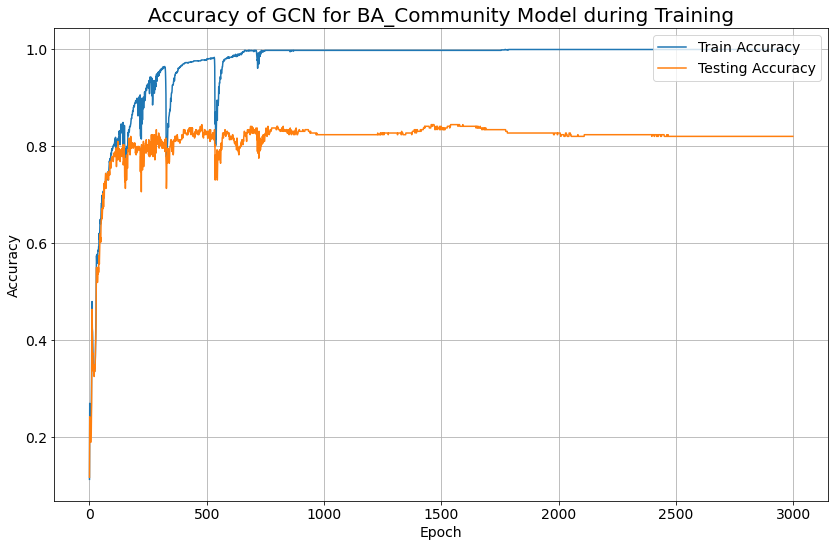

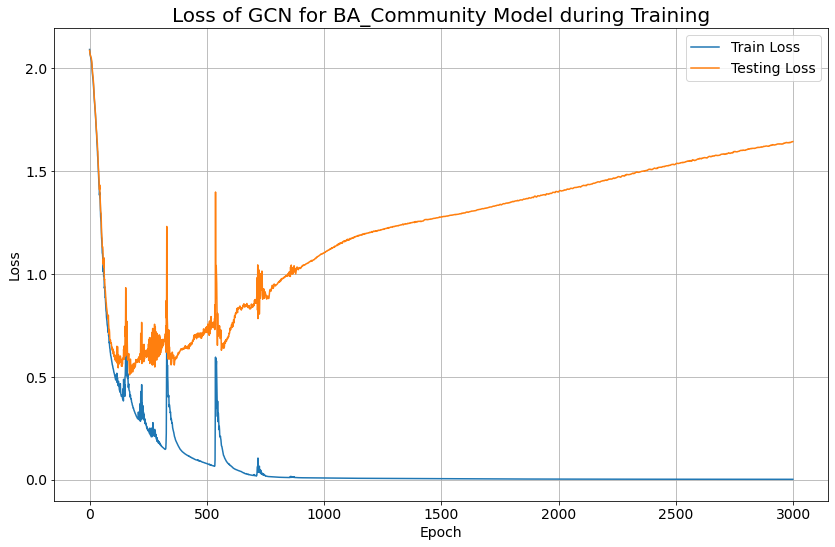

Num clusters:  157
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 40, cluster_encoding_size: 10


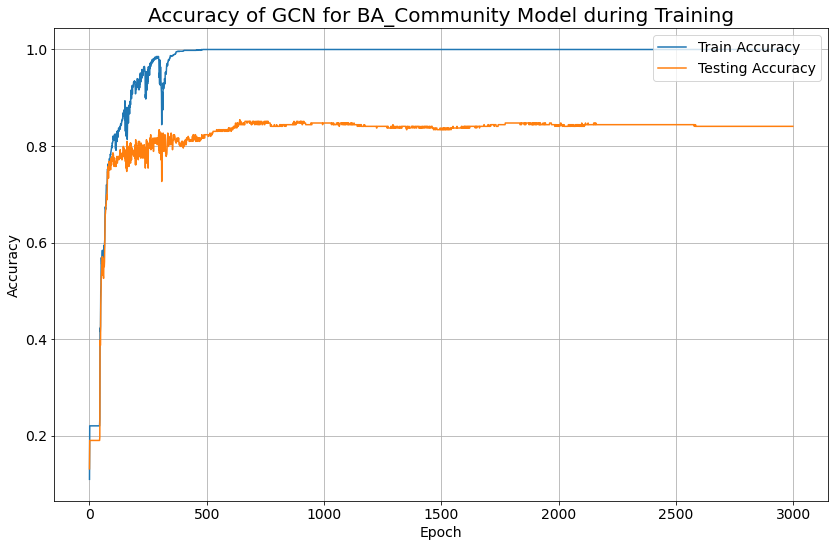

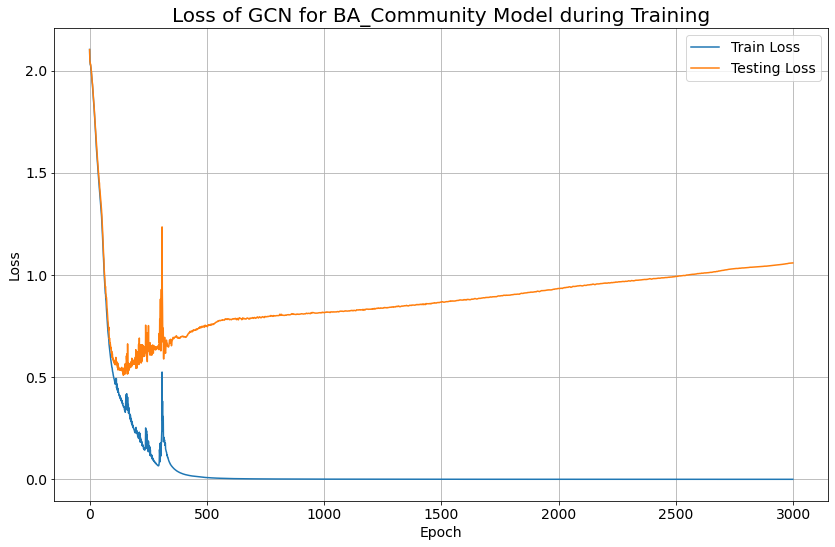

Num clusters:  389
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 40, cluster_encoding_size: 20


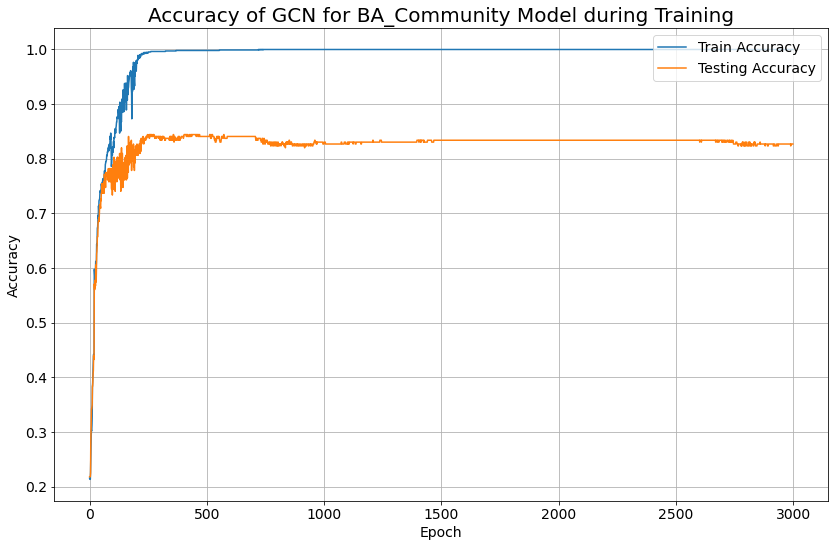

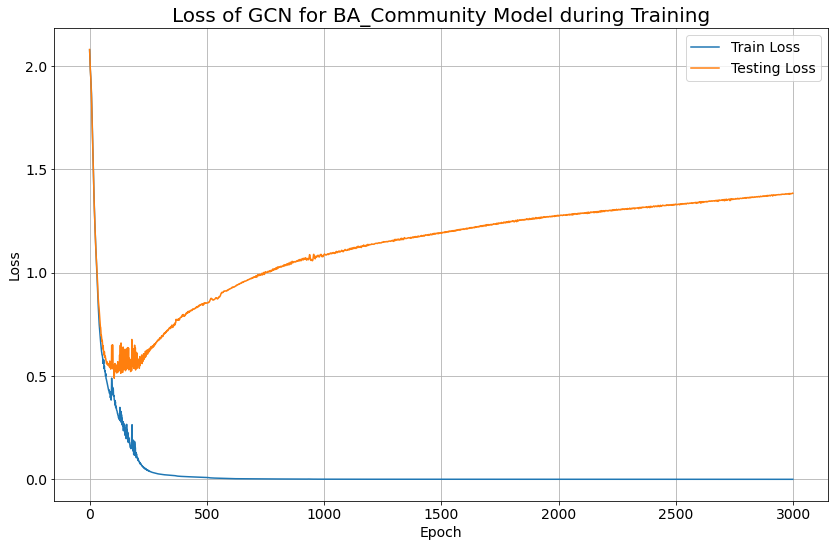

Num clusters:  743
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 40, cluster_encoding_size: 30


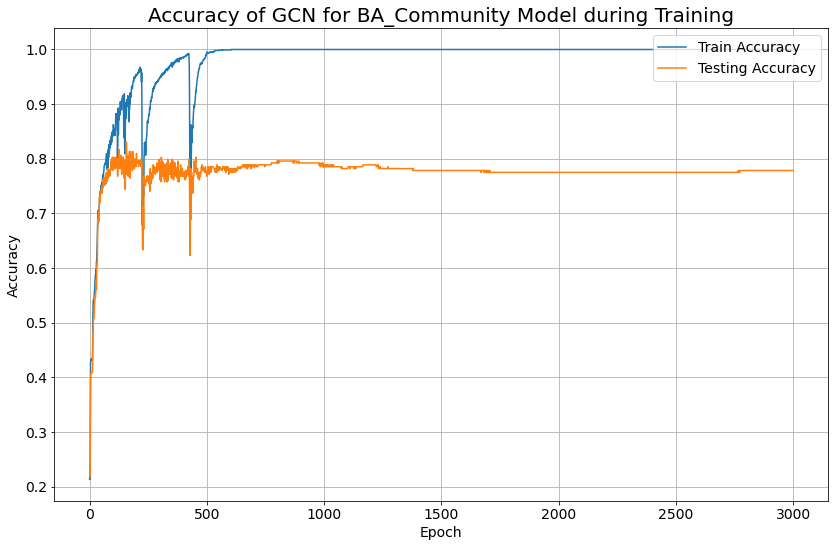

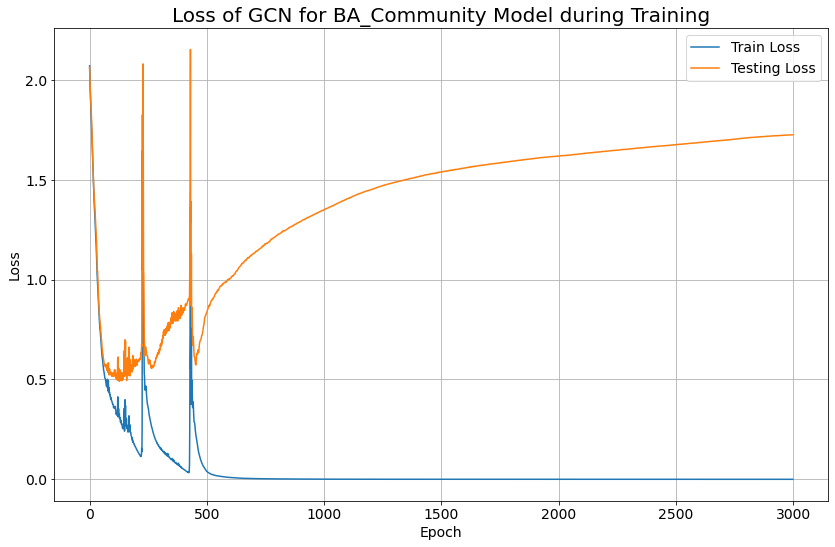

Num clusters:  953
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 40, cluster_encoding_size: 5


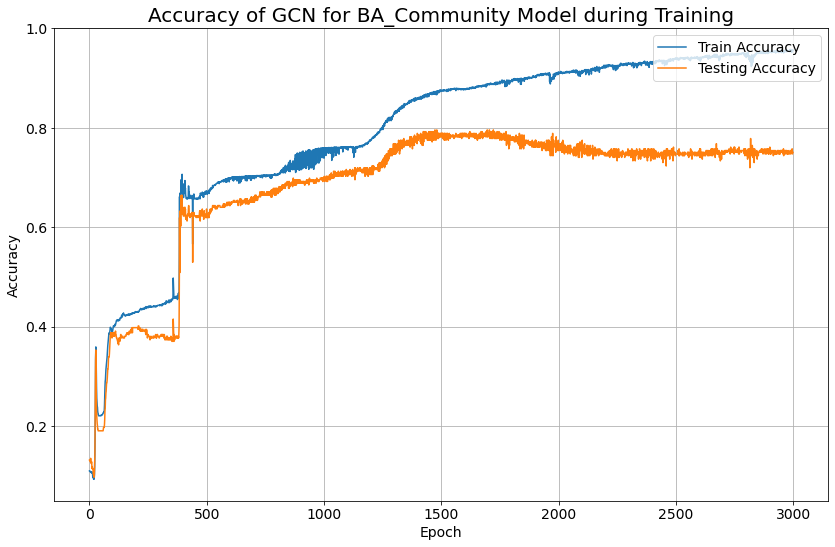

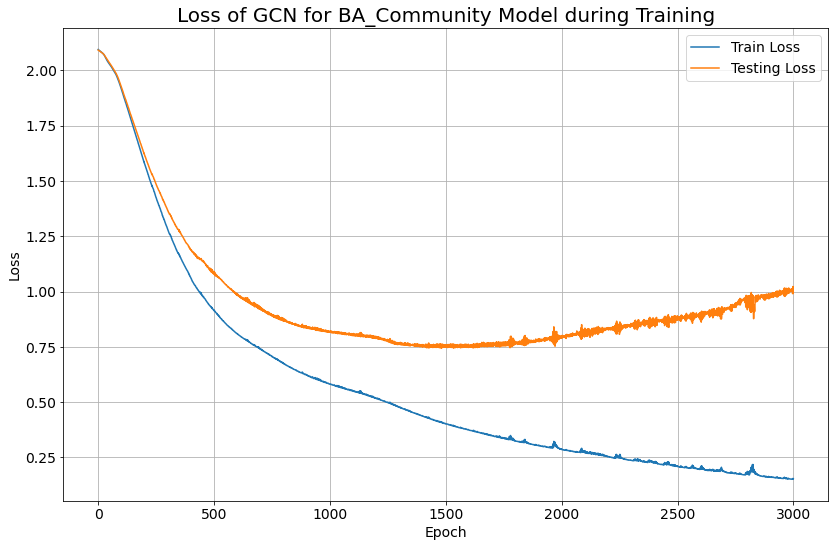

Num clusters:  145
Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 40, cluster_encoding_size: 10


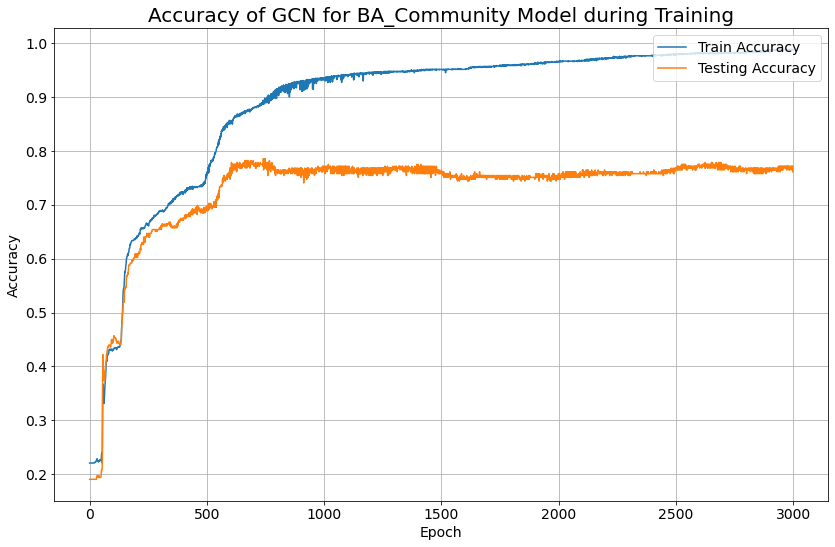

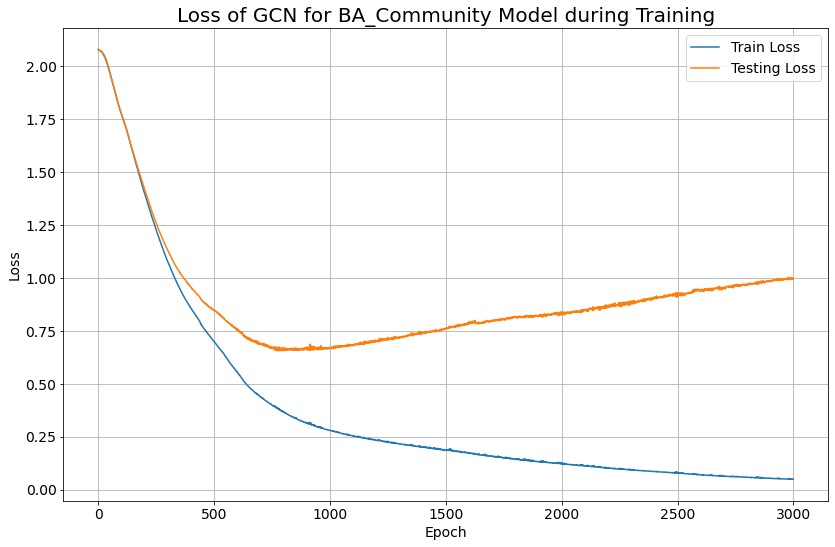

Num clusters:  349
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 40, cluster_encoding_size: 20


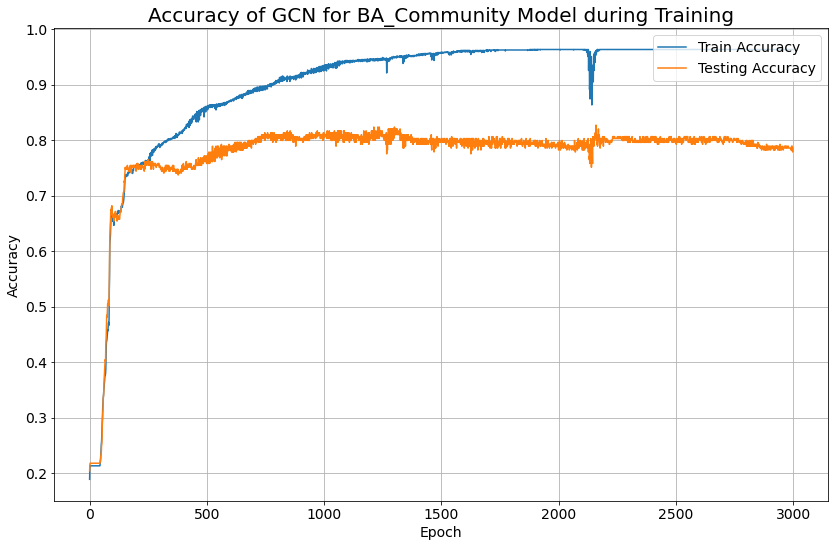

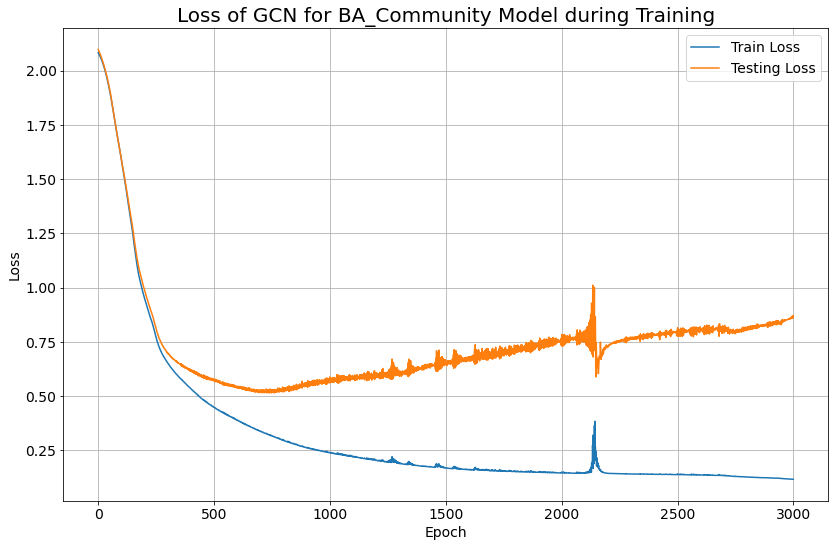

Num clusters:  621
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 40, cluster_encoding_size: 30


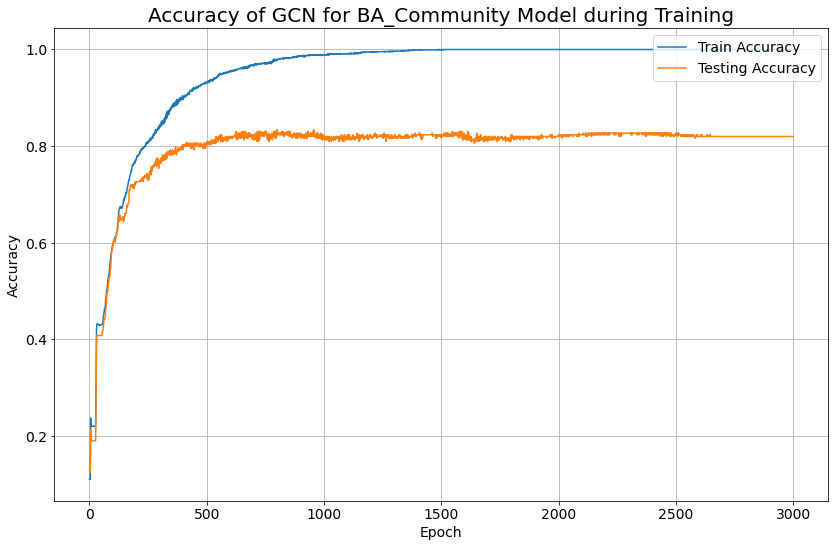

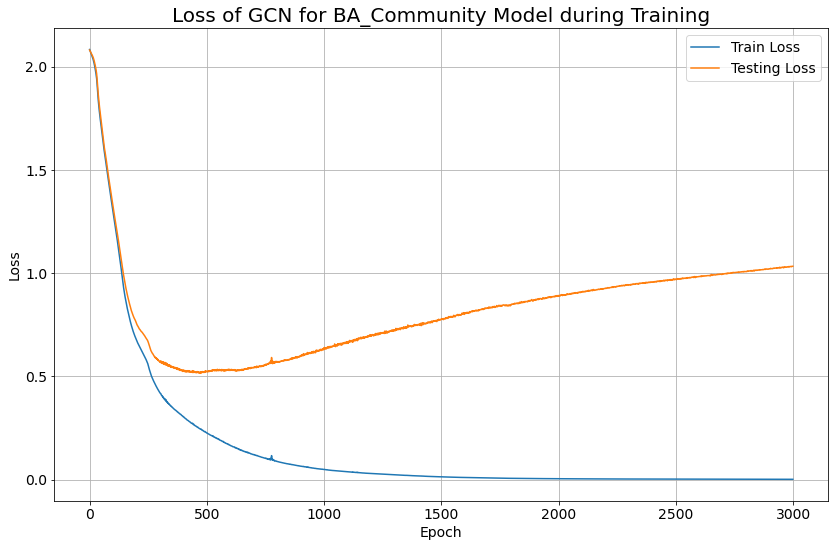

Num clusters:  932
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 40, cluster_encoding_size: 5


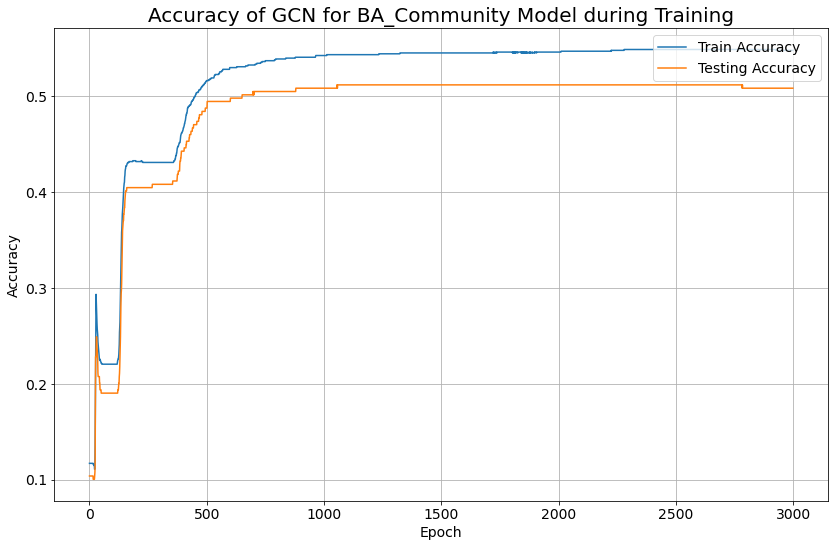

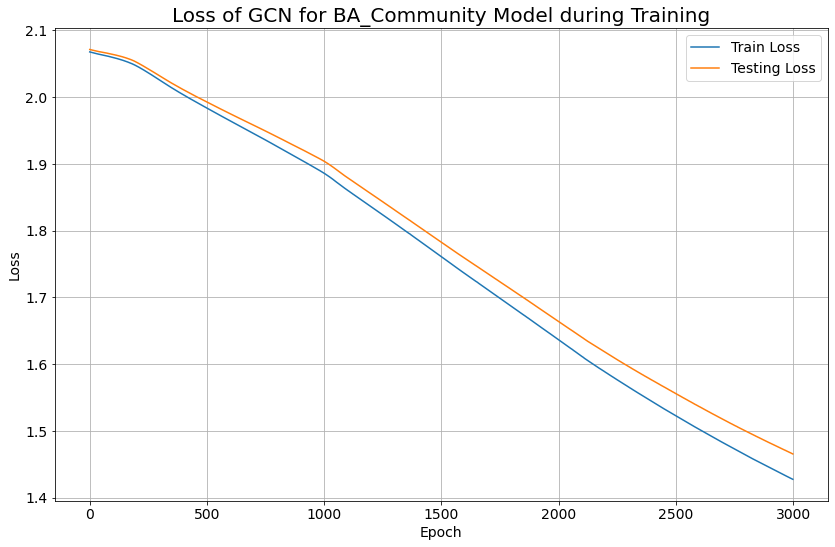

Num clusters:  17
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 40, cluster_encoding_size: 10


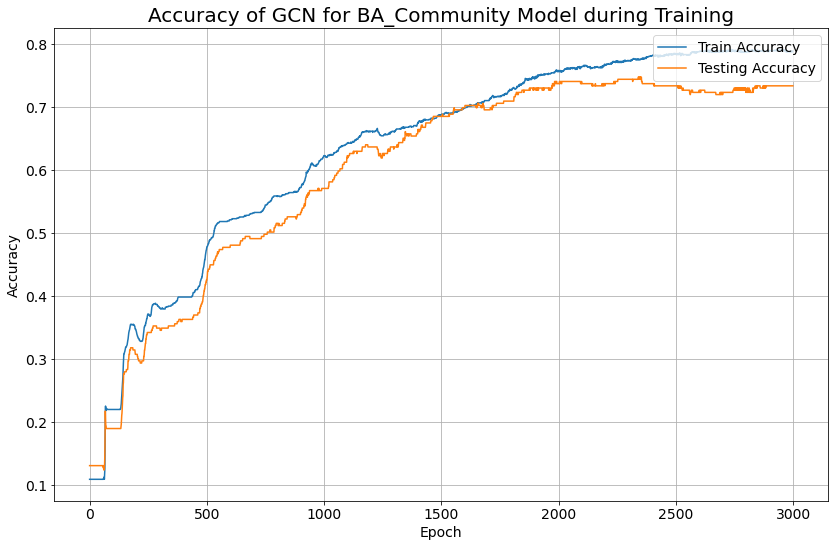

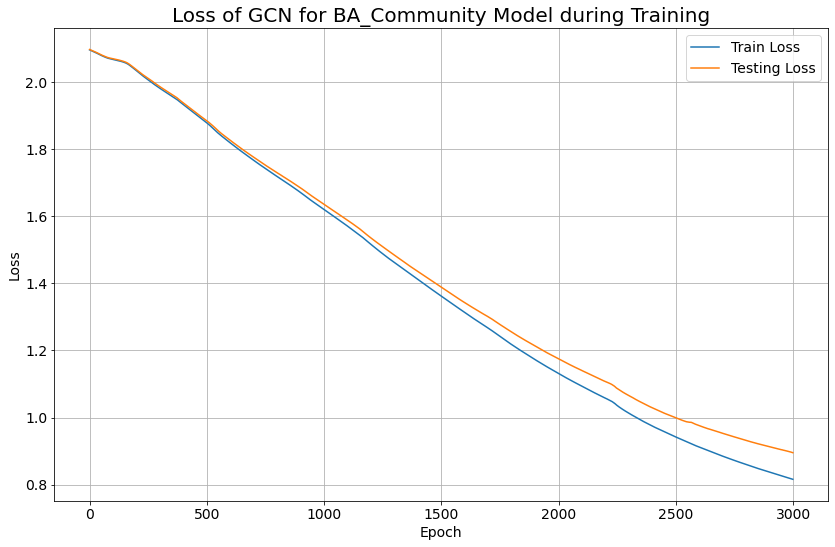

Num clusters:  92
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 40, cluster_encoding_size: 20


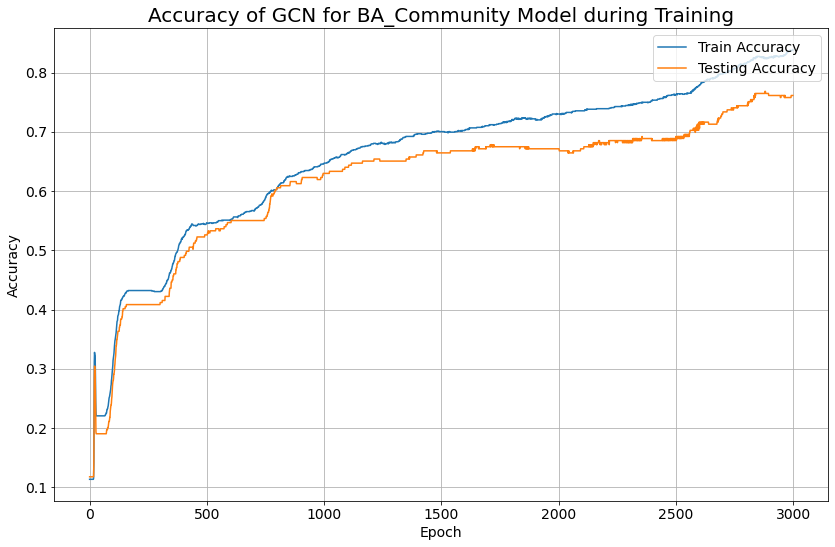

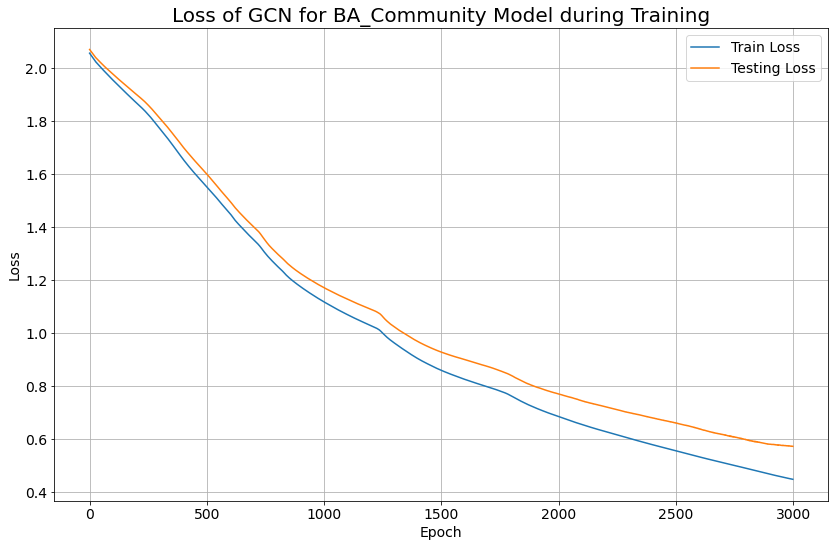

Num clusters:  390
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 40, cluster_encoding_size: 30


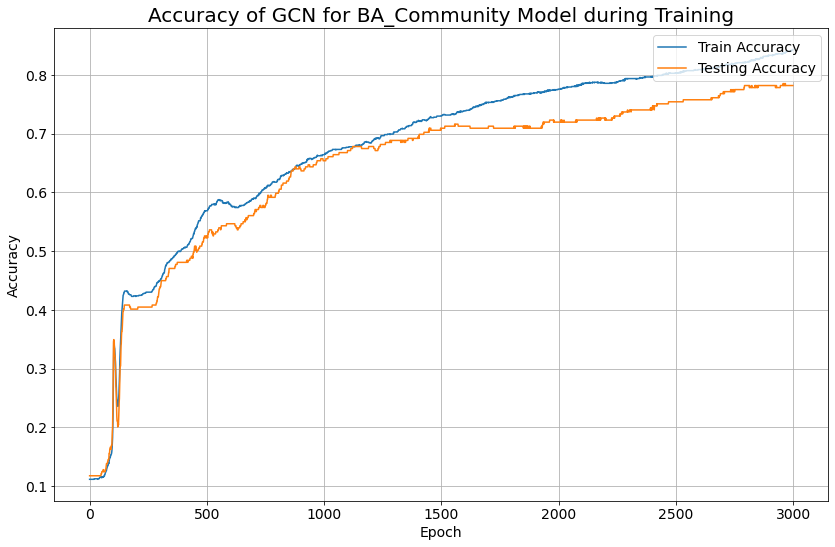

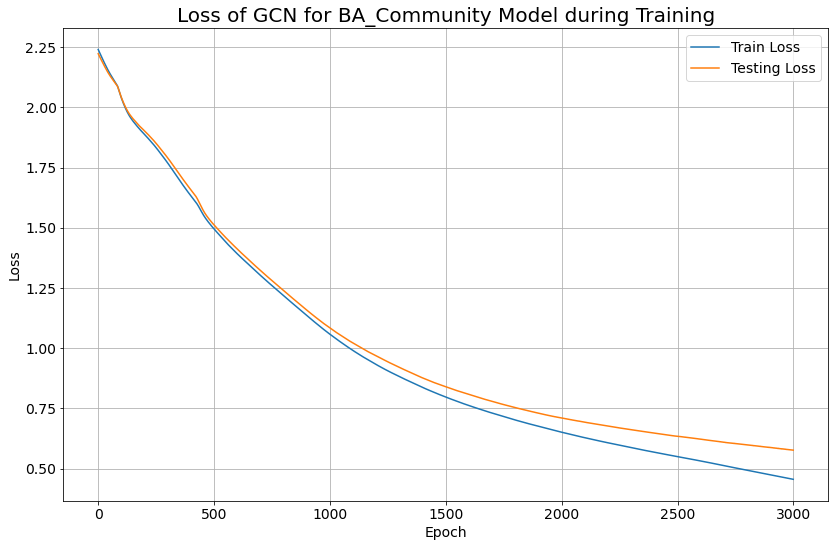

Num clusters:  463
Explanation class 0:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 1:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 2:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 3:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 4: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 5:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 6:  - acc. = 0.0000 - compl. = 0.0000
Explanation class 7:  - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------



In [7]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
lr_values = [0.01, 0.001, 0.0001]
hidden_units_values = [40]
cluster_encoding_size_values = [5, 10, 20, 30]

for lr in lr_values:
    for hidden_units in hidden_units_values:
        for cluster_encoding_size in cluster_encoding_size_values:
            print("\nSTART EXPERIMENT-----------------------------------------\n")
            print(f"lr: {lr}, hu: {hidden_units}, cluster_encoding_size: {cluster_encoding_size}")

            path = os.path.join("..", "..", "output", "grid_search", DATASET_NAME, f"seed_{seed}_lr_{lr}_hu_{hidden_units}_cluster_{cluster_encoding_size}")
            data_utils.create_path(path)
            
            run_grid_search(data, lr, hidden_units, cluster_encoding_size, path)

            print("\nEND EXPERIMENT-------------------------------------------\n")